# Introduction


For this project I decided to create a model that would be able to predict the **severity of anxiety attacks**.

# Imports

In [1]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib as plt
import xarray as xr
import bambi as bmb

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Data Collection

In [2]:
#imported the data on to github and used pandas to read it 
link = "https://raw.githubusercontent.com/ashwingeeni12/data_science_fundamentals/refs/heads/main/Unit_6/anxiety_attack_dataset.csv"
anxiety_data = pd.read_csv(link)

anxiety_data

Occupation  Sleep_Hours  Physical_Activity  Caffeine_Intake  \
0          Other          9.6                8.3              175   
1        Teacher          6.4                7.3               97   
2         Doctor          6.9                1.0              467   
3         Doctor          9.2                3.7              471   
4        Student          9.2                2.5              364   
...          ...          ...                ...              ...   
11995   Engineer          4.4                4.1              360   
11996     Doctor          9.9                2.2              433   
11997    Student          9.8                8.1              140   
11998    Teacher          5.9                6.6              114   
11999    Teacher          6.6                7.8              114   

       Alcohol_Consumption  Stress_Level  Heart_Rate  Breathing_Rate  \
0                        6             4         145              33   
1                        6             3         143              18   
2                       14             2          60              34   
3                       16             6          94              19   
4                        2             7         152              15   
...                    ...           ...         ...             ...   
11995                    1             1         139              20   
11996                    4             4         150              33   
11997                   19             2          81              33   
11998                   12             9          90              14   
11999                    0             7         107              19   

       Sweating_Level  Therapy_Sessions  Diet_Quality  \
0                   3                 4             9   
1                   5                 0             9   
2                   1                 7            10   
3                   1                 4             5   
4                   4                 0             1   
...               ...               ...           ...   
11995               2                 7             9   
11996               2                 3             5   
11997               2                 8             1   
11998               5                 3             9   
11999               2                 3             8   

       Severity_of_Anxiety_Attack  
0                              10  
1                               8  
2                               5  
3                               8  
4                               1  
...                           ...  
11995                           6  
11996                           6  
11997                          10  
11998                           5  
11999                           2  

[12000 rows x 12 columns]

# Variable Selection

One thing about my dataset is that it has many variables, 10 to be exact. Heres how they all relate shown through my casual DAG.
<img src="u6projectdag.jpg" style = "width:800px;height:400px"/>

To help create my models I grouped the variables into different categories. Before I explain the different categories I want to establish that I will be treating Occupation as a categorical variable through a hierarchy because peoples job can have a heavy toll on their mental health, eg anxiety, but different jobs will have have different effects as an engineer wouldn't feel the same as a doctor because doctors may experience trauma from patients, something engineers don't deal with. 

In [3]:
anxiety_data["Occupation"].astype('category')

0           Other
1         Teacher
2          Doctor
3          Doctor
4         Student
           ...   
11995    Engineer
11996      Doctor
11997     Student
11998     Teacher
11999     Teacher
Name: Occupation, Length: 12000, dtype: category
Categories (6, object): ['Doctor', 'Engineer', 'Other', 'Student', 'Teacher', 'Unemployed']

My first grouping will be variables that have to do with **your comsumption and exercise habits**. The variables in here will be *Alcohol Consumption*, *Caffenine Intake*, *Diet Quality*, and *Physical Activity*. Alcohol consumption and caffenine intake are directly related to diet quality and if you have a good diet then you probably are health concious meaning you have good physical activity too. From my DAG all of these variables relate to severity of an anxiety attack either through *Stress Level* and *Heart Rate* so I will make a variation of this grouping using those variables as well.

My next grouping will be variables that have to do with you **Physiological Response**. The variables in here will be *Heart Rate*, *Breathing Rate*, *Sweating Level* which all were recorded during the anxiety attack itself. I also want to include a variation with Physical Activity having an interaction with heart rate because if you are active your resting heart rate would be lower so that could affect your heart rate in a anxiety attack and having an interaction with breathing rate and therapy session because therapy can help you during an anxiety attack by giving tools such as breating exercises which would affect your breath rate.  

Another grouping that I thought of was **Lifestyle & Behavioral Factors**. The variables here are *Diet Quality*, *Physical Activity*, *Sleep Hours*, and *Therapy Sessions*. I want to include a variation that has stress level as well because all of these variables have an affect on stress level, including Occupation. I also want to see an interaction between ocupation and sleep hours.

Finally I will have one model with all the variables that directly point to severity of an anxiety attack and one model representing my DAG.

# My Models

For my first model I just want to get a base line with all of my variables with no interactions

In [25]:
model1_base = bmb.Model("Severity_of_Anxiety_Attack ~ (Sleep_Hours + Physical_Activity + Caffeine_Intake+ Alcohol_Consumption + Stress_Level + " 
                   "Heart_Rate + Breathing_Rate + Sweating_Level + Therapy_Sessions + Diet_Quality | Occupation)", 
                   data=anxiety_data)

idata_model1_base = model1_base.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|Occupation_sigma, 1|Occupation_offset, Sleep_Hours|Occupation_sigma, Sleep_Hours|Occupation_offset, Physical_Activity|Occupation_sigma, Physical_Activity|Occupation_offset, Caffeine_Intake|Occupation_sigma, Caffeine_Intake|Occupation_offset, Alcohol_Consumption|Occupation_sigma, Alcohol_Consumption|Occupation_offset, Stress_Level|Occupation_sigma, Stress_Level|Occupation_offset, Heart_Rate|Occupation_sigma, Heart_Rate|Occupation_offset, Breathing_Rate|Occupation_sigma, Breathing_Rate|Occupation_offset, Sweating_Level|Occupation_sigma, Sweating_Level|Occupation_offset, Therapy_Sessions|Occupation_sigma, Therapy_Sessions|Occupation_offset, Diet_Quality|Occupation_sigma, Diet_Quality|Occupation_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 527 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.


In [26]:
model1_direct = bmb.Model("Severity_of_Anxiety_Attack ~ ((Stress_Level + Heart_Rate + Breathing_Rate + Sweating_Level + Therapy_Sessions) | Occupation)", 
                   data=anxiety_data)

idata_model1_direct = model1_direct.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|Occupation_sigma, 1|Occupation_offset, Stress_Level|Occupation_sigma, Stress_Level|Occupation_offset, Heart_Rate|Occupation_sigma, Heart_Rate|Occupation_offset, Breathing_Rate|Occupation_sigma, Breathing_Rate|Occupation_offset, Sweating_Level|Occupation_sigma, Sweating_Level|Occupation_offset, Therapy_Sessions|Occupation_sigma, Therapy_Sessions|Occupation_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 221 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.


In [29]:
model1_dag = bmb.Model("Severity_of_Anxiety_Attack ~ Stress_Level + Heart_Rate + Breathing_Rate + Sweating_Level + Therapy_Sessions + "
                   "Alcohol_Consumption : Heart_Rate + Caffeine_Intake : Heart_Rate + Diet_Quality : Heart_Rate + Physical_Activity : Heart_Rate + "
                   "Physical_Activity : Stress_Level + Diet_Quality : Stress_Level + Sleep_Hours : Stress_Level + Occupation : Stress_Level + " 
                   "Physical_Activity : Diet_Quality + Caffeine_Intake : Diet_Quality + Alcohol_Consumption : Diet_Quality + "
                   "Caffeine_Intake : Sleep_Hours + Occupation : Sleep_Hours + "
                   "Breathing_Rate : Therapy_Sessions + Occupation : Therapy_Sessions",
                   data=anxiety_data)

idata_model1_dag = model1_dag.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, Stress_Level, Heart_Rate, Breathing_Rate, Sweating_Level, Therapy_Sessions, Alcohol_Consumption:Heart_Rate, Caffeine_Intake:Heart_Rate, Diet_Quality:Heart_Rate, Physical_Activity:Heart_Rate, Physical_Activity:Stress_Level, Diet_Quality:Stress_Level, Sleep_Hours:Stress_Level, Occupation:Stress_Level, Physical_Activity:Diet_Quality, Caffeine_Intake:Diet_Quality, Alcohol_Consumption:Diet_Quality, Caffeine_Intake:Sleep_Hours, Occupation:Sleep_Hours, Breathing_Rate:Therapy_Sessions, Occupation:Therapy_Sessions]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 885 seconds.


# Consumption and Exercise Habits

This next model I will be using my first group one without any interactions (no including stress level and heart rate), then have one model with all variables interacting with heart rate, one with diet quality and physical activity interacting with stress level, one with alcohol consumption and caffeine intake interacting with diet quality along with an interaction between diet quality and physical activity, and then models combing the interactions to get all possiblites. One one with heart rate and stress level, one with heart rate and diet quality (the last one in the list), and one with stress level and diet quality (the last one in the list).

In [30]:
model2_no_interactions = bmb.Model("Severity_of_Anxiety_Attack ~ ((Physical_Activity + Alcohol_Consumption + Caffeine_Intake + Diet_Quality) | Occupation)", 
    data=anxiety_data)

idata_model2_no_interactions = model2_no_interactions.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|Occupation_sigma, 1|Occupation_offset, Physical_Activity|Occupation_sigma, Physical_Activity|Occupation_offset, Alcohol_Consumption|Occupation_sigma, Alcohol_Consumption|Occupation_offset, Caffeine_Intake|Occupation_sigma, Caffeine_Intake|Occupation_offset, Diet_Quality|Occupation_sigma, Diet_Quality|Occupation_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 220 seconds.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


In [31]:
model2_heartrate_interaction = bmb.Model(
    "Severity_of_Anxiety_Attack ~ ((Physical_Activity + Alcohol_Consumption + Caffeine_Intake + Diet_Quality + "
    "Physical_Activity : Heart_Rate + Alcohol_Consumption : Heart_Rate + Caffeine_Intake : Heart_Rate + Diet_Quality : Heart_Rate) | Occupation)",
    data=anxiety_data)

idata_model2_heartrate_interaction = model2_heartrate_interaction.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|Occupation_sigma, 1|Occupation_offset, Physical_Activity|Occupation_sigma, Physical_Activity|Occupation_offset, Alcohol_Consumption|Occupation_sigma, Alcohol_Consumption|Occupation_offset, Caffeine_Intake|Occupation_sigma, Caffeine_Intake|Occupation_offset, Diet_Quality|Occupation_sigma, Diet_Quality|Occupation_offset, Physical_Activity:Heart_Rate|Occupation_sigma, Physical_Activity:Heart_Rate|Occupation_offset, Alcohol_Consumption:Heart_Rate|Occupation_sigma, Alcohol_Consumption:Heart_Rate|Occupation_offset, Caffeine_Intake:Heart_Rate|Occupation_sigma, Caffeine_Intake:Heart_Rate|Occupation_offset, Diet_Quality:Heart_Rate|Occupation_sigma, Diet_Quality:Heart_Rate|Occupation_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 552 seconds.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.


In [32]:
model2_stresslevel_interaction = bmb.Model(
    "Severity_of_Anxiety_Attack ~ ((Physical_Activity + Alcohol_Consumption + Caffeine_Intake + Diet_Quality + "
    "Physical_Activity : Stress_Level + Diet_Quality : Stress_Level) | Occupation)",
    data=anxiety_data)

idata_model2_stresslevel_interaction = model2_stresslevel_interaction.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|Occupation_sigma, 1|Occupation_offset, Physical_Activity|Occupation_sigma, Physical_Activity|Occupation_offset, Alcohol_Consumption|Occupation_sigma, Alcohol_Consumption|Occupation_offset, Caffeine_Intake|Occupation_sigma, Caffeine_Intake|Occupation_offset, Diet_Quality|Occupation_sigma, Diet_Quality|Occupation_offset, Physical_Activity:Stress_Level|Occupation_sigma, Physical_Activity:Stress_Level|Occupation_offset, Diet_Quality:Stress_Level|Occupation_sigma, Diet_Quality:Stress_Level|Occupation_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1545 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


In [33]:
model2_dietquality_interaction = bmb.Model(
    "Severity_of_Anxiety_Attack ~ ((Physical_Activity + Alcohol_Consumption + Caffeine_Intake + Diet_Quality + "
    "Physical_Activity : Diet_Quality + Alcohol_Consumption : Diet_Quality + Caffeine_Intake : Diet_Quality) | Occupation)",
    data=anxiety_data)

idata_model2_dietquality_interaction = model2_dietquality_interaction.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|Occupation_sigma, 1|Occupation_offset, Physical_Activity|Occupation_sigma, Physical_Activity|Occupation_offset, Alcohol_Consumption|Occupation_sigma, Alcohol_Consumption|Occupation_offset, Caffeine_Intake|Occupation_sigma, Caffeine_Intake|Occupation_offset, Diet_Quality|Occupation_sigma, Diet_Quality|Occupation_offset, Physical_Activity:Diet_Quality|Occupation_sigma, Physical_Activity:Diet_Quality|Occupation_offset, Alcohol_Consumption:Diet_Quality|Occupation_sigma, Alcohol_Consumption:Diet_Quality|Occupation_offset, Caffeine_Intake:Diet_Quality|Occupation_sigma, Caffeine_Intake:Diet_Quality|Occupation_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 546 seconds.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [34]:
model2_heartrate_stresslevel_interaction = bmb.Model(
    "Severity_of_Anxiety_Attack ~ ((Physical_Activity + Alcohol_Consumption + Caffeine_Intake + Diet_Quality + "
    "Physical_Activity : Heart_Rate + Alcohol_Consumption : Heart_Rate + Caffeine_Intake : Heart_Rate + Diet_Quality : Heart_Rate + "
    "Physical_Activity : Stress_Level + Diet_Quality : Stress_Level) | Occupation)",
    data=anxiety_data)

idata_model2_heartrate_stresslevel_interaction = model2_heartrate_stresslevel_interaction.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|Occupation_sigma, 1|Occupation_offset, Physical_Activity|Occupation_sigma, Physical_Activity|Occupation_offset, Alcohol_Consumption|Occupation_sigma, Alcohol_Consumption|Occupation_offset, Caffeine_Intake|Occupation_sigma, Caffeine_Intake|Occupation_offset, Diet_Quality|Occupation_sigma, Diet_Quality|Occupation_offset, Physical_Activity:Heart_Rate|Occupation_sigma, Physical_Activity:Heart_Rate|Occupation_offset, Alcohol_Consumption:Heart_Rate|Occupation_sigma, Alcohol_Consumption:Heart_Rate|Occupation_offset, Caffeine_Intake:Heart_Rate|Occupation_sigma, Caffeine_Intake:Heart_Rate|Occupation_offset, Diet_Quality:Heart_Rate|Occupation_sigma, Diet_Quality:Heart_Rate|Occupation_offset, Physical_Activity:Stress_Level|Occupation_sigma, Physical_Activity:Stress_Level|Occupation_offset, Diet_Quality:Stress_Level|Occupation_sigma, Diet_Quality:Stress_Level|Occupation_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 722 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.


In [35]:
model2_heartrate_dietquality_interaction = bmb.Model(
    "Severity_of_Anxiety_Attack ~ ((Physical_Activity + Alcohol_Consumption + Caffeine_Intake + Diet_Quality + "
    "Physical_Activity : Heart_Rate + Alcohol_Consumption : Heart_Rate + Caffeine_Intake : Heart_Rate + Diet_Quality : Heart_Rate + "
    "Physical_Activity : Diet_Quality + Alcohol_Consumption : Diet_Quality + Caffeine_Intake : Diet_Quality) | Occupation)",
    data=anxiety_data)

idata_model2_heartrate_dietquality_interaction = model2_heartrate_dietquality_interaction.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|Occupation_sigma, 1|Occupation_offset, Physical_Activity|Occupation_sigma, Physical_Activity|Occupation_offset, Alcohol_Consumption|Occupation_sigma, Alcohol_Consumption|Occupation_offset, Caffeine_Intake|Occupation_sigma, Caffeine_Intake|Occupation_offset, Diet_Quality|Occupation_sigma, Diet_Quality|Occupation_offset, Physical_Activity:Heart_Rate|Occupation_sigma, Physical_Activity:Heart_Rate|Occupation_offset, Alcohol_Consumption:Heart_Rate|Occupation_sigma, Alcohol_Consumption:Heart_Rate|Occupation_offset, Caffeine_Intake:Heart_Rate|Occupation_sigma, Caffeine_Intake:Heart_Rate|Occupation_offset, Diet_Quality:Heart_Rate|Occupation_sigma, Diet_Quality:Heart_Rate|Occupation_offset, Physical_Activity:Diet_Quality|Occupation_sigma, Physical_Activity:Diet_Quality|Occupation_offset, Alcohol_Consumption:Diet_Quality|Occupation_sigma, Alcohol_Consumption:Diet_Quality|Occupation_

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 633 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.


In [36]:
model2_stresslevel_dietquality_interaction = bmb.Model(
    "Severity_of_Anxiety_Attack ~ ((Physical_Activity + Alcohol_Consumption + Caffeine_Intake + Diet_Quality + "
    "Physical_Activity : Stress_Level + Diet_Quality : Stress_Level + "
    "Physical_Activity : Diet_Quality + Alcohol_Consumption : Diet_Quality + Caffeine_Intake : Diet_Quality) | Occupation)",
    data=anxiety_data)

idata_model2_stresslevel_dietquality_interaction = model2_stresslevel_dietquality_interaction.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|Occupation_sigma, 1|Occupation_offset, Physical_Activity|Occupation_sigma, Physical_Activity|Occupation_offset, Alcohol_Consumption|Occupation_sigma, Alcohol_Consumption|Occupation_offset, Caffeine_Intake|Occupation_sigma, Caffeine_Intake|Occupation_offset, Diet_Quality|Occupation_sigma, Diet_Quality|Occupation_offset, Physical_Activity:Stress_Level|Occupation_sigma, Physical_Activity:Stress_Level|Occupation_offset, Diet_Quality:Stress_Level|Occupation_sigma, Diet_Quality:Stress_Level|Occupation_offset, Physical_Activity:Diet_Quality|Occupation_sigma, Physical_Activity:Diet_Quality|Occupation_offset, Alcohol_Consumption:Diet_Quality|Occupation_sigma, Alcohol_Consumption:Diet_Quality|Occupation_offset, Caffeine_Intake:Diet_Quality|Occupation_sigma, Caffeine_Intake:Diet_Quality|Occupation_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 680 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.


In [37]:
model2_all_interaction = bmb.Model(
    "Severity_of_Anxiety_Attack ~ ((Physical_Activity + Alcohol_Consumption + Caffeine_Intake + Diet_Quality + "
    "Physical_Activity : Heart_Rate + Alcohol_Consumption : Heart_Rate + Caffeine_Intake : Heart_Rate + Diet_Quality : Heart_Rate + "
    "Physical_Activity : Stress_Level + Diet_Quality : Stress_Level + "
    "Physical_Activity : Diet_Quality + Alcohol_Consumption : Diet_Quality + Caffeine_Intake : Diet_Quality) | Occupation)",
    data=anxiety_data)

idata_model2_all_interaction = model2_all_interaction.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|Occupation_sigma, 1|Occupation_offset, Physical_Activity|Occupation_sigma, Physical_Activity|Occupation_offset, Alcohol_Consumption|Occupation_sigma, Alcohol_Consumption|Occupation_offset, Caffeine_Intake|Occupation_sigma, Caffeine_Intake|Occupation_offset, Diet_Quality|Occupation_sigma, Diet_Quality|Occupation_offset, Physical_Activity:Heart_Rate|Occupation_sigma, Physical_Activity:Heart_Rate|Occupation_offset, Alcohol_Consumption:Heart_Rate|Occupation_sigma, Alcohol_Consumption:Heart_Rate|Occupation_offset, Caffeine_Intake:Heart_Rate|Occupation_sigma, Caffeine_Intake:Heart_Rate|Occupation_offset, Diet_Quality:Heart_Rate|Occupation_sigma, Diet_Quality:Heart_Rate|Occupation_offset, Physical_Activity:Stress_Level|Occupation_sigma, Physical_Activity:Stress_Level|Occupation_offset, Diet_Quality:Stress_Level|Occupation_sigma, Diet_Quality:Stress_Level|Occupation_offset, Physic

Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1131 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.


# Physiological Response

This next model I will be using my second group one without interactions, one with heart rate x physical activity interaction, one with breathing rate x therapy sessions interaction, and one with both

In [38]:
model3_no_interaction = bmb.Model("Severity_of_Anxiety_Attack ~ ((Heart_Rate + Breathing_Rate + Sweating_Level) | Occupation)", 
    data=anxiety_data)

idata_model3_no_interactions = model3_no_interaction.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|Occupation_sigma, 1|Occupation_offset, Heart_Rate|Occupation_sigma, Heart_Rate|Occupation_offset, Breathing_Rate|Occupation_sigma, Breathing_Rate|Occupation_offset, Sweating_Level|Occupation_sigma, Sweating_Level|Occupation_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 303 seconds.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.


In [39]:
model3_physicalactivity_interaction = bmb.Model(
   "Severity_of_Anxiety_Attack ~ ((Heart_Rate + Breathing_Rate + Sweating_Level + "
   "Heart_Rate : Physical_Activity) | Occupation)",
   data=anxiety_data)

idata_model3_physicalactivity_interaction = model3_physicalactivity_interaction.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|Occupation_sigma, 1|Occupation_offset, Heart_Rate|Occupation_sigma, Heart_Rate|Occupation_offset, Breathing_Rate|Occupation_sigma, Breathing_Rate|Occupation_offset, Sweating_Level|Occupation_sigma, Sweating_Level|Occupation_offset, Heart_Rate:Physical_Activity|Occupation_sigma, Heart_Rate:Physical_Activity|Occupation_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 340 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [40]:
model3_therapysessions_interaction = bmb.Model(
   "Severity_of_Anxiety_Attack ~ ((Heart_Rate + Breathing_Rate + Sweating_Level + "
   "Breathing_Rate : Therapy_Sessions) | Occupation)",
   data=anxiety_data)

idata_model3_therapysessions_interaction = model3_therapysessions_interaction.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|Occupation_sigma, 1|Occupation_offset, Heart_Rate|Occupation_sigma, Heart_Rate|Occupation_offset, Breathing_Rate|Occupation_sigma, Breathing_Rate|Occupation_offset, Sweating_Level|Occupation_sigma, Sweating_Level|Occupation_offset, Breathing_Rate:Therapy_Sessions|Occupation_sigma, Breathing_Rate:Therapy_Sessions|Occupation_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 375 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.


In [41]:
model3_both_interaction = bmb.Model(
   "Severity_of_Anxiety_Attack ~ ((Heart_Rate + Breathing_Rate + Sweating_Level + "
   "Heart_Rate : Physical_Activity + "
   "Breathing_Rate : Therapy_Sessions) | Occupation)",
   data=anxiety_data)

idata_model3_both_interaction = model3_both_interaction.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|Occupation_sigma, 1|Occupation_offset, Heart_Rate|Occupation_sigma, Heart_Rate|Occupation_offset, Breathing_Rate|Occupation_sigma, Breathing_Rate|Occupation_offset, Sweating_Level|Occupation_sigma, Sweating_Level|Occupation_offset, Heart_Rate:Physical_Activity|Occupation_sigma, Heart_Rate:Physical_Activity|Occupation_offset, Breathing_Rate:Therapy_Sessions|Occupation_sigma, Breathing_Rate:Therapy_Sessions|Occupation_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 230 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.


# Lifestyle & Behavioral Factors

This next model I will be using my third group with one with no interaction, and one with all of them interacting with stress level.

In [42]:
model4_no_interaction = bmb.Model(
   "Severity_of_Anxiety_Attack ~ ((Physical_Activity + Diet_Quality + Sleep_Hours + Therapy_Sessions) | Occupation)", data=anxiety_data)

idata_model4_no_interaction = model4_no_interaction.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|Occupation_sigma, 1|Occupation_offset, Physical_Activity|Occupation_sigma, Physical_Activity|Occupation_offset, Diet_Quality|Occupation_sigma, Diet_Quality|Occupation_offset, Sleep_Hours|Occupation_sigma, Sleep_Hours|Occupation_offset, Therapy_Sessions|Occupation_sigma, Therapy_Sessions|Occupation_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 161 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.


In [44]:
model4_stresslevel_interaction = bmb.Model(
   "Severity_of_Anxiety_Attack ~ ((Physical_Activity + Diet_Quality + Sleep_Hours + Therapy_Sessions + "
   "Occupation : Stress_Level + Physical_Activity : Stress_Level + Diet_Quality : Stress_Level + Sleep_Hours : Stress_Level + Therapy_Sessions : Stress_Level) | Occupation)", 
   data=anxiety_data)

idata_model4_stresslevel_interaction = model4_stresslevel_interaction.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|Occupation_sigma, 1|Occupation_offset, Physical_Activity|Occupation_sigma, Physical_Activity|Occupation_offset, Diet_Quality|Occupation_sigma, Diet_Quality|Occupation_offset, Sleep_Hours|Occupation_sigma, Sleep_Hours|Occupation_offset, Therapy_Sessions|Occupation_sigma, Therapy_Sessions|Occupation_offset, Occupation:Stress_Level|Occupation_sigma, Occupation:Stress_Level|Occupation_offset, Physical_Activity:Stress_Level|Occupation_sigma, Physical_Activity:Stress_Level|Occupation_offset, Diet_Quality:Stress_Level|Occupation_sigma, Diet_Quality:Stress_Level|Occupation_offset, Sleep_Hours:Stress_Level|Occupation_sigma, Sleep_Hours:Stress_Level|Occupation_offset, Therapy_Sessions:Stress_Level|Occupation_sigma, Therapy_Sessions:Stress_Level|Occupation_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2052 seconds.
There were 1143 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [45]:
model4_sleephours_interaction = bmb.Model(
   "Severity_of_Anxiety_Attack ~ ((Physical_Activity + Diet_Quality + Sleep_Hours + Therapy_Sessions + "
   "Occupation : Sleep_Hours) | Occupation)", 
   data=anxiety_data)

idata_model4_sleephours_interaction = model4_sleephours_interaction.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|Occupation_sigma, 1|Occupation_offset, Physical_Activity|Occupation_sigma, Physical_Activity|Occupation_offset, Diet_Quality|Occupation_sigma, Diet_Quality|Occupation_offset, Sleep_Hours|Occupation_sigma, Sleep_Hours|Occupation_offset, Therapy_Sessions|Occupation_sigma, Therapy_Sessions|Occupation_offset, Occupation:Sleep_Hours|Occupation_sigma, Occupation:Sleep_Hours|Occupation_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1309 seconds.
There were 1466 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [46]:
model4_both_interaction = bmb.Model(
   "Severity_of_Anxiety_Attack ~ ((Physical_Activity + Diet_Quality + Sleep_Hours + Therapy_Sessions + "
   "Occupation : Stress_Level + Physical_Activity : Stress_Level + Diet_Quality : Stress_Level + Sleep_Hours : Stress_Level + Therapy_Sessions : Stress_Level + " 
   "Occupation : Sleep_Hours) | Occupation)",
   data=anxiety_data)

idata_model4_both_interaction = model4_both_interaction.fit(idata_kwargs={'log_likelihood': True})

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, 1|Occupation_sigma, 1|Occupation_offset, Physical_Activity|Occupation_sigma, Physical_Activity|Occupation_offset, Diet_Quality|Occupation_sigma, Diet_Quality|Occupation_offset, Sleep_Hours|Occupation_sigma, Sleep_Hours|Occupation_offset, Therapy_Sessions|Occupation_sigma, Therapy_Sessions|Occupation_offset, Occupation:Stress_Level|Occupation_sigma, Occupation:Stress_Level|Occupation_offset, Physical_Activity:Stress_Level|Occupation_sigma, Physical_Activity:Stress_Level|Occupation_offset, Diet_Quality:Stress_Level|Occupation_sigma, Diet_Quality:Stress_Level|Occupation_offset, Sleep_Hours:Stress_Level|Occupation_sigma, Sleep_Hours:Stress_Level|Occupation_offset, Therapy_Sessions:Stress_Level|Occupation_sigma, Therapy_Sessions:Stress_Level|Occupation_offset, Occupation:Sleep_Hours|Occupation_sigma, Occupation:Sleep_Hours|Occupation_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3928 seconds.
There were 874 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


# elpd_loo

Time to see which model is better. 

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

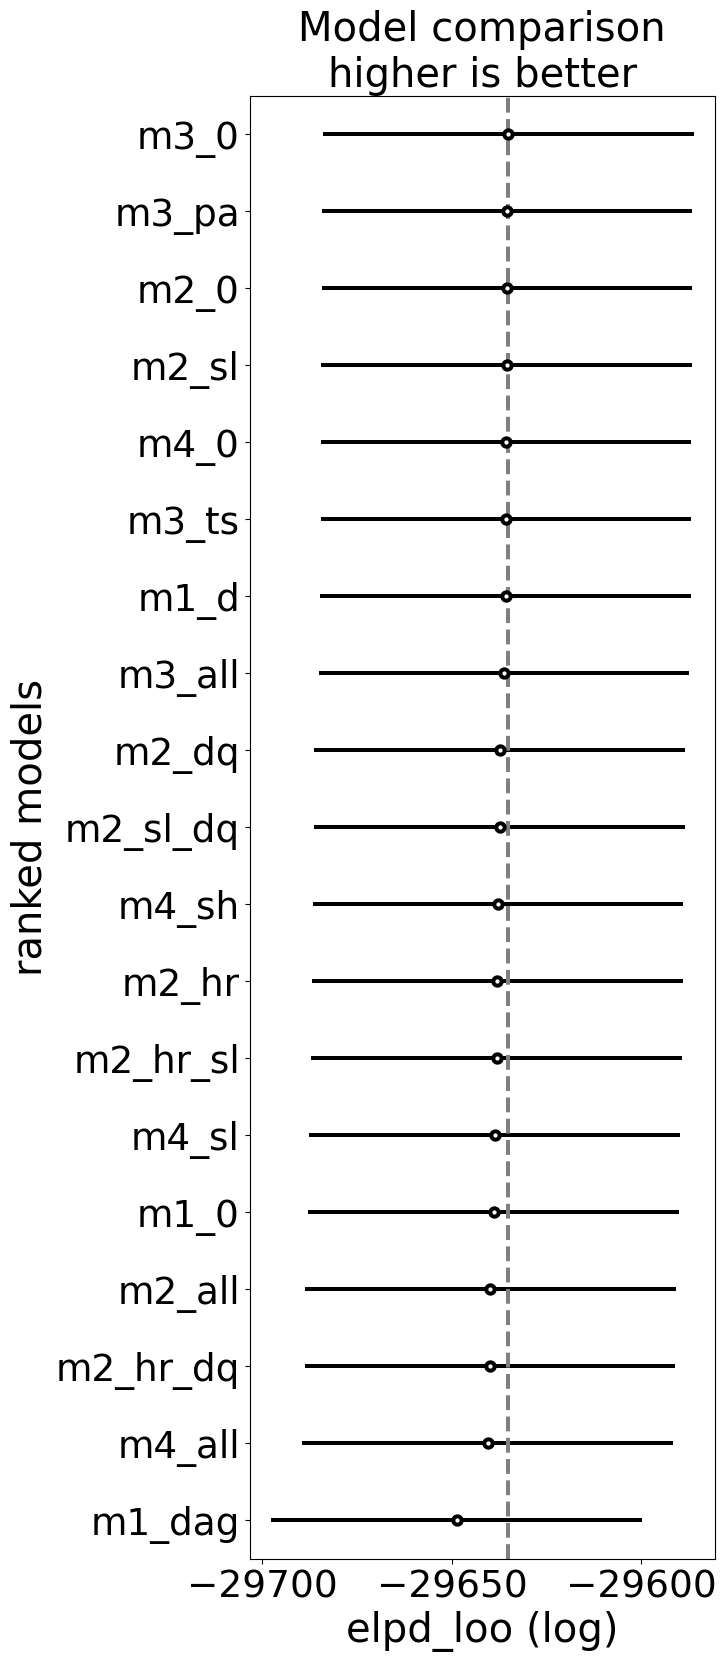

In [48]:
cmp = az.compare({"m1_0":idata_model1_base, "m1_d":idata_model1_direct, "m1_dag":idata_model1_dag ,"m2_0":idata_model2_no_interactions, "m2_hr":idata_model2_heartrate_interaction, "m2_sl":idata_model2_stresslevel_interaction,
"m2_dq":idata_model2_dietquality_interaction, "m2_hr_sl":idata_model2_heartrate_stresslevel_interaction, "m2_hr_dq":idata_model2_heartrate_dietquality_interaction, 
"m2_sl_dq":idata_model2_stresslevel_dietquality_interaction, "m2_all":idata_model2_all_interaction, "m3_0":idata_model3_no_interactions, 
"m3_pa":idata_model3_physicalactivity_interaction, "m3_ts":idata_model3_therapysessions_interaction, "m3_all":idata_model3_both_interaction, 
"m4_0":idata_model4_no_interaction, "m4_sl":idata_model4_stresslevel_interaction, "m4_sh":idata_model4_sleephours_interaction, "m4_all":idata_model4_both_interaction})
az.plot_compare(cmp)

# Visualizations and Conclusions

So what does this tell us. Well there seems to be no connection between all these variables and the severity of an anxiety attack. We can come to this conclusion because when comparing the error bars from our elpd_loo comparison we see there is barely any freaking difference. However just to see our top 2 models how they look I have made graphs for them. Interestingly the top 2 models are both from our 3rd set which is the physiological response factors. One thing to point out is that with my dataset all of it is self reported so there could be numerous reasons as to why there is no connection, question bias and unstandardized way of measuring stress, anxiety are the mains ones I can think of.   

This is going to be the model 3 no interaction visualization and since i have 4 variables i will just make multiple graphs with the different combinations of 3 variables 

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: Heart_Rate, Occupation, Breathing_Rate
Default computed for unspecified variable: Sweating_Level


(<Figure size 2200x2600 with 28 Axes>,
 array([[<Axes: title={'center': 'Breathing_Rate = 12'}, xlabel='Heart_Rate', ylabel='Severity_of_Anxiety_Attack'>,
         <Axes: title={'center': 'Breathing_Rate = 13'}, xlabel='Heart_Rate', ylabel='Severity_of_Anxiety_Attack'>,
         <Axes: title={'center': 'Breathing_Rate = 14'}, xlabel='Heart_Rate', ylabel='Severity_of_Anxiety_Attack'>,
         <Axes: title={'center': 'Breathing_Rate = 15'}, xlabel='Heart_Rate', ylabel='Severity_of_Anxiety_Attack'>],
        [<Axes: title={'center': 'Breathing_Rate = 16'}, xlabel='Heart_Rate', ylabel='Severity_of_Anxiety_Attack'>,
         <Axes: title={'center': 'Breathing_Rate = 17'}, xlabel='Heart_Rate', ylabel='Severity_of_Anxiety_Attack'>,
         <Axes: title={'center': 'Breathing_Rate = 18'}, xlabel='Heart_Rate', ylabel='Severity_of_Anxiety_Attack'>,
         <Axes: title={'center': 'Breathing_Rate = 19'}, xlabel='Heart_Rate', ylabel='Severity_of_Anxiety_Attack'>],
        [<Axes: title={'center'

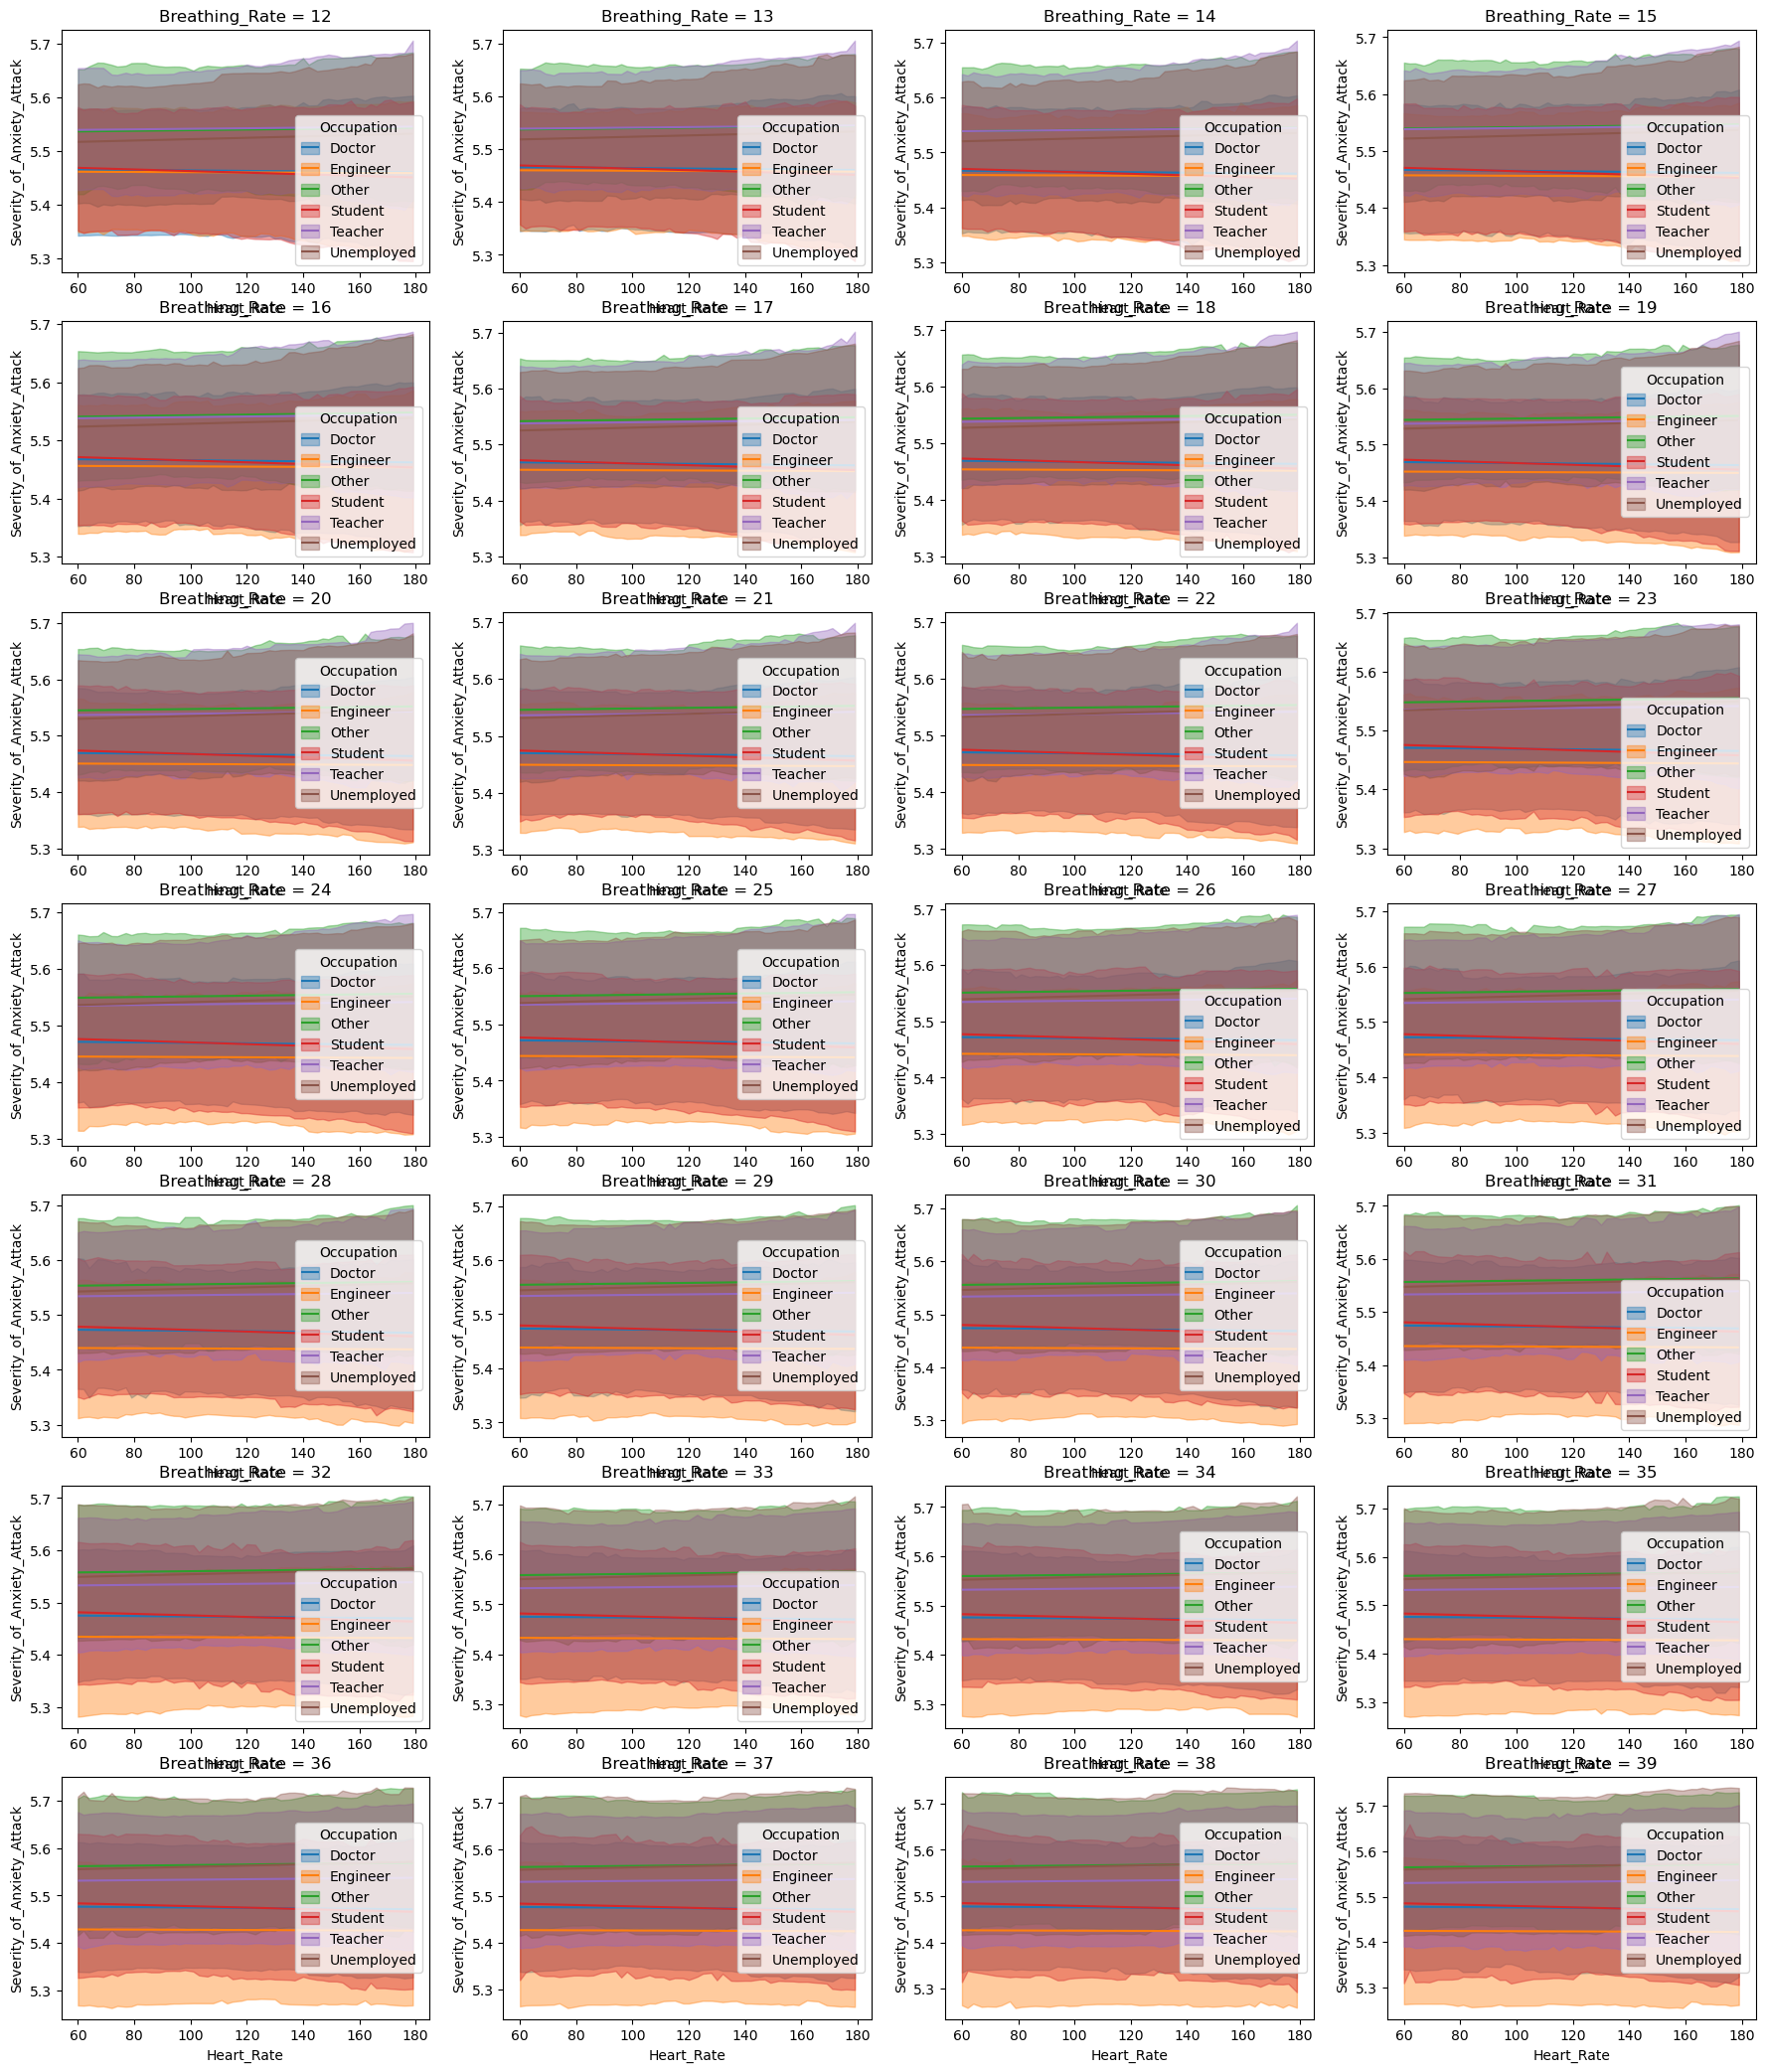

In [55]:

bmb.interpret.plot_predictions(
    model3_no_interaction,
    idata_model3_no_interactions,
    ["Heart_Rate", "Occupation", "Breathing_Rate"],
    fig_kwargs={"figsize":(22, 26)})#,
    #legend=False)
     

Default computed for conditional variable: Heart_Rate, Occupation, Sweating_Level
Default computed for unspecified variable: Breathing_Rate


(<Figure size 2200x2600 with 6 Axes>,
 array([[<Axes: title={'center': 'Sweating_Level = 1'}, xlabel='Heart_Rate', ylabel='Severity_of_Anxiety_Attack'>,
         <Axes: title={'center': 'Sweating_Level = 2'}, xlabel='Heart_Rate', ylabel='Severity_of_Anxiety_Attack'>,
         <Axes: title={'center': 'Sweating_Level = 3'}, xlabel='Heart_Rate', ylabel='Severity_of_Anxiety_Attack'>],
        [<Axes: title={'center': 'Sweating_Level = 4'}, xlabel='Heart_Rate', ylabel='Severity_of_Anxiety_Attack'>,
         <Axes: title={'center': 'Sweating_Level = 5'}, xlabel='Heart_Rate', ylabel='Severity_of_Anxiety_Attack'>,
         <Axes: xlabel='Heart_Rate', ylabel='Severity_of_Anxiety_Attack'>]],
       dtype=object))

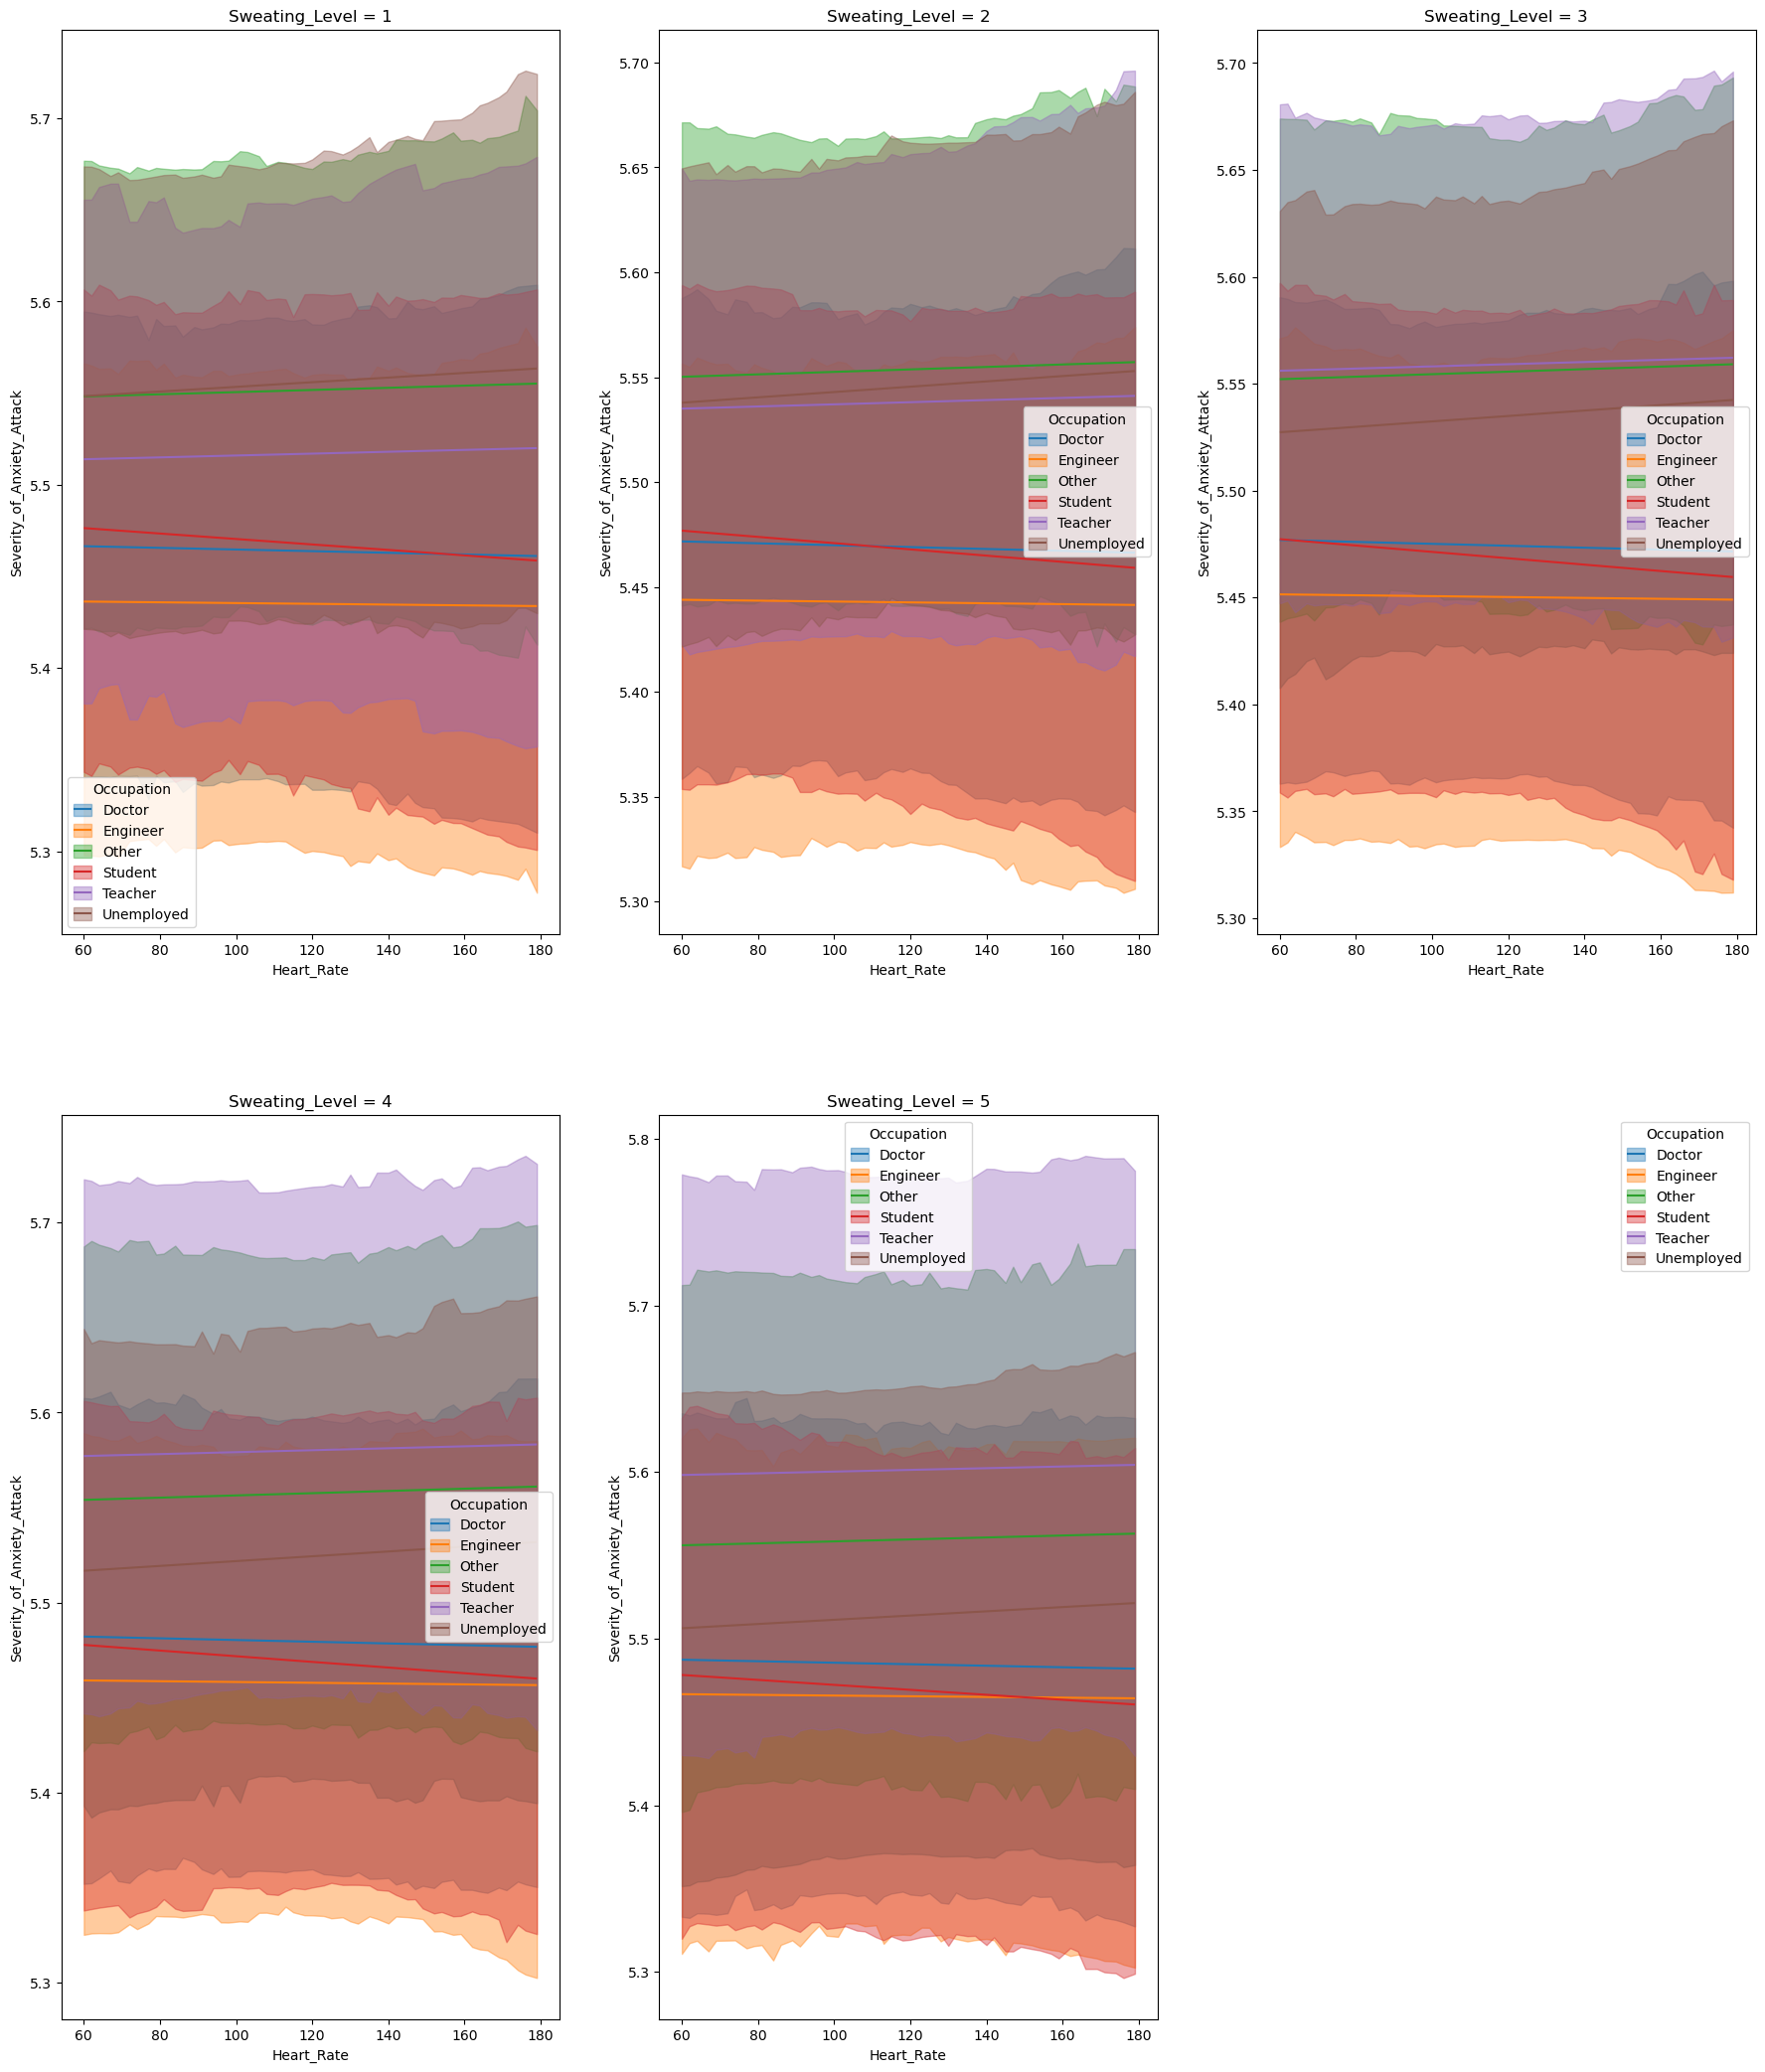

In [57]:
bmb.interpret.plot_predictions(
    model3_no_interaction,
    idata_model3_no_interactions,
    ["Heart_Rate", "Occupation", "Sweating_Level"],
    fig_kwargs={"figsize":(22, 26)})#,
    #legend=False)
     

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: Breathing_Rate, Occupation, Sweating_Level
Default computed for unspecified variable: Heart_Rate


(<Figure size 2200x2600 with 6 Axes>,
 array([[<Axes: title={'center': 'Sweating_Level = 1'}, xlabel='Breathing_Rate', ylabel='Severity_of_Anxiety_Attack'>,
         <Axes: title={'center': 'Sweating_Level = 2'}, xlabel='Breathing_Rate', ylabel='Severity_of_Anxiety_Attack'>,
         <Axes: title={'center': 'Sweating_Level = 3'}, xlabel='Breathing_Rate', ylabel='Severity_of_Anxiety_Attack'>],
        [<Axes: title={'center': 'Sweating_Level = 4'}, xlabel='Breathing_Rate', ylabel='Severity_of_Anxiety_Attack'>,
         <Axes: title={'center': 'Sweating_Level = 5'}, xlabel='Breathing_Rate', ylabel='Severity_of_Anxiety_Attack'>,
         <Axes: xlabel='Breathing_Rate', ylabel='Severity_of_Anxiety_Attack'>]],
       dtype=object))

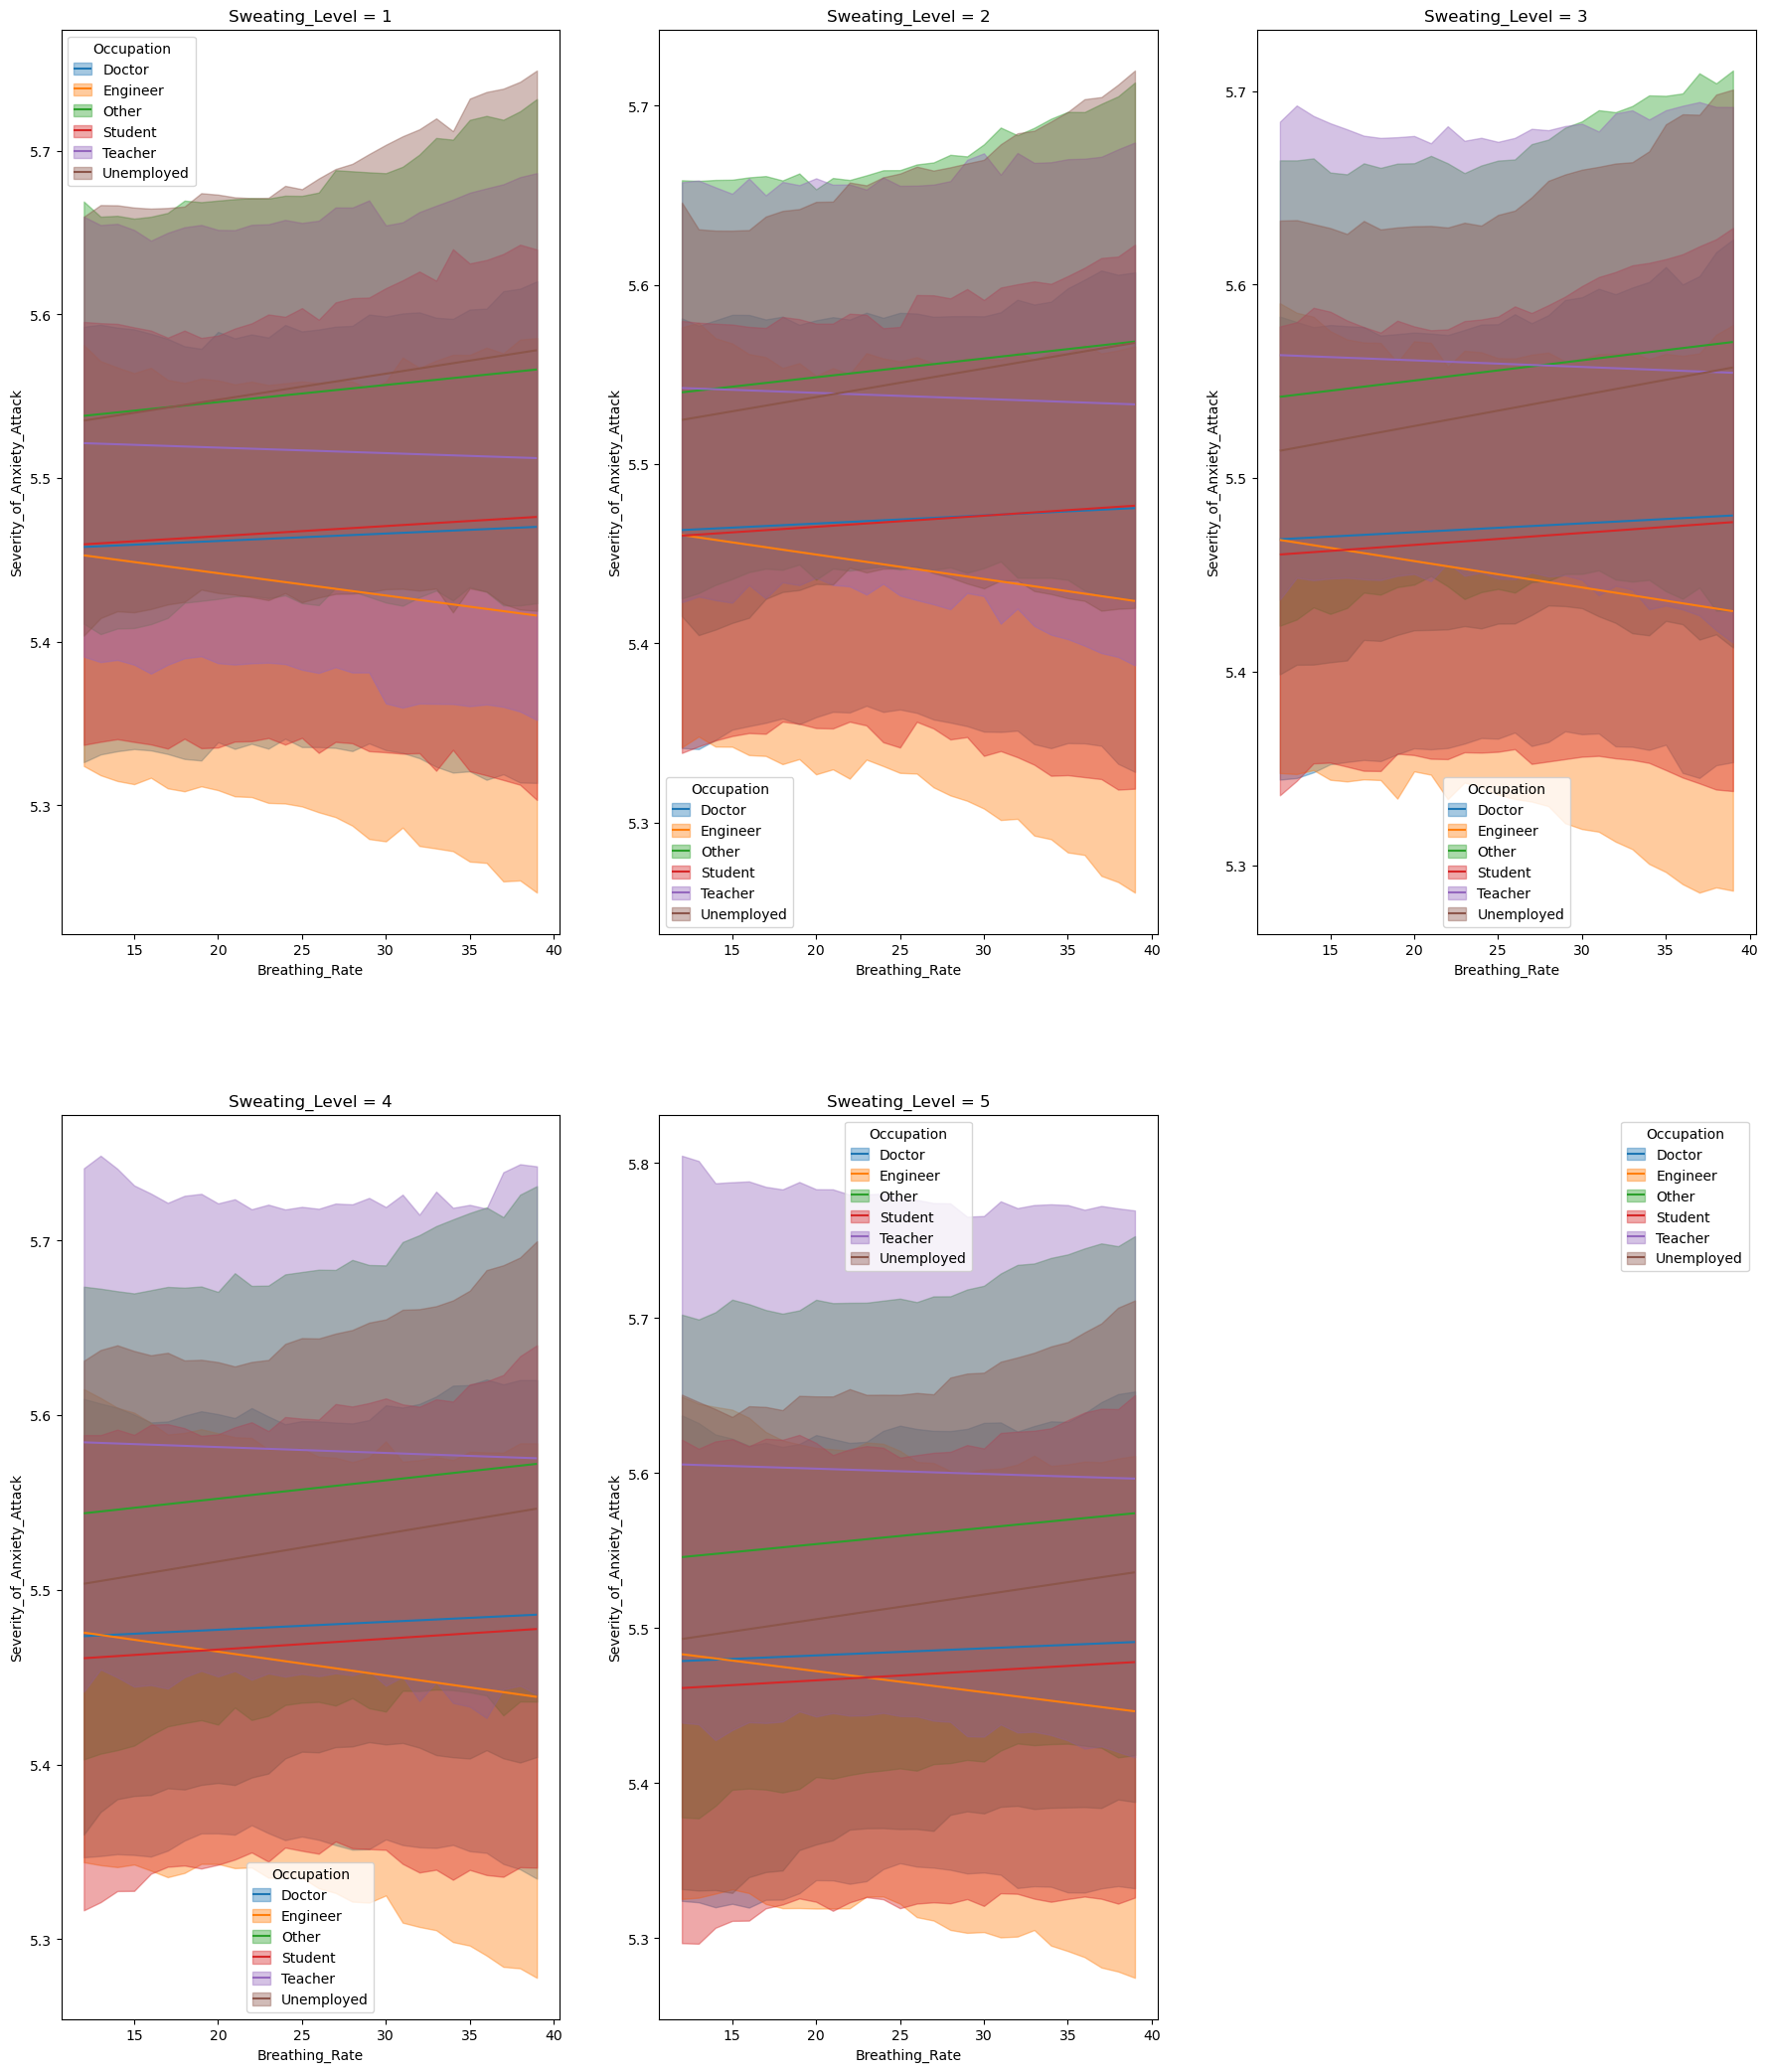

In [58]:
bmb.interpret.plot_predictions(
    model3_no_interaction,
    idata_model3_no_interactions,
    ["Breathing_Rate", "Occupation", "Sweating_Level"],
    fig_kwargs={"figsize":(22, 26)})#,
    #legend=False)
     

To summarize what I can get from the graphs: 
Anxiety severity is largely stable across physiological factors with only small changes.
Occupation remains a strong independent factor, unaffected by changes in these physiological variables.
Sweating Level appears to have the most uniform impact on anxiety severity, while Heart Rate and Breathing Rate show slightly more distributional shifts.
Any differences observed are minor, meaning that their isn't a direct connection.

Now lets do it again for the other model and see what we find, predication : i think it will be more of the same. This next model instead of just being physiological variables I included an interaction between physical activity 

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: Heart_Rate, Occupation, Breathing_Rate
Default computed for unspecified variable: Physical_Activity, Sweating_Level


(<Figure size 2200x2600 with 28 Axes>,
 array([[<Axes: title={'center': 'Breathing_Rate = 12'}, xlabel='Heart_Rate', ylabel='Severity_of_Anxiety_Attack'>,
         <Axes: title={'center': 'Breathing_Rate = 13'}, xlabel='Heart_Rate', ylabel='Severity_of_Anxiety_Attack'>,
         <Axes: title={'center': 'Breathing_Rate = 14'}, xlabel='Heart_Rate', ylabel='Severity_of_Anxiety_Attack'>,
         <Axes: title={'center': 'Breathing_Rate = 15'}, xlabel='Heart_Rate', ylabel='Severity_of_Anxiety_Attack'>],
        [<Axes: title={'center': 'Breathing_Rate = 16'}, xlabel='Heart_Rate', ylabel='Severity_of_Anxiety_Attack'>,
         <Axes: title={'center': 'Breathing_Rate = 17'}, xlabel='Heart_Rate', ylabel='Severity_of_Anxiety_Attack'>,
         <Axes: title={'center': 'Breathing_Rate = 18'}, xlabel='Heart_Rate', ylabel='Severity_of_Anxiety_Attack'>,
         <Axes: title={'center': 'Breathing_Rate = 19'}, xlabel='Heart_Rate', ylabel='Severity_of_Anxiety_Attack'>],
        [<Axes: title={'center'

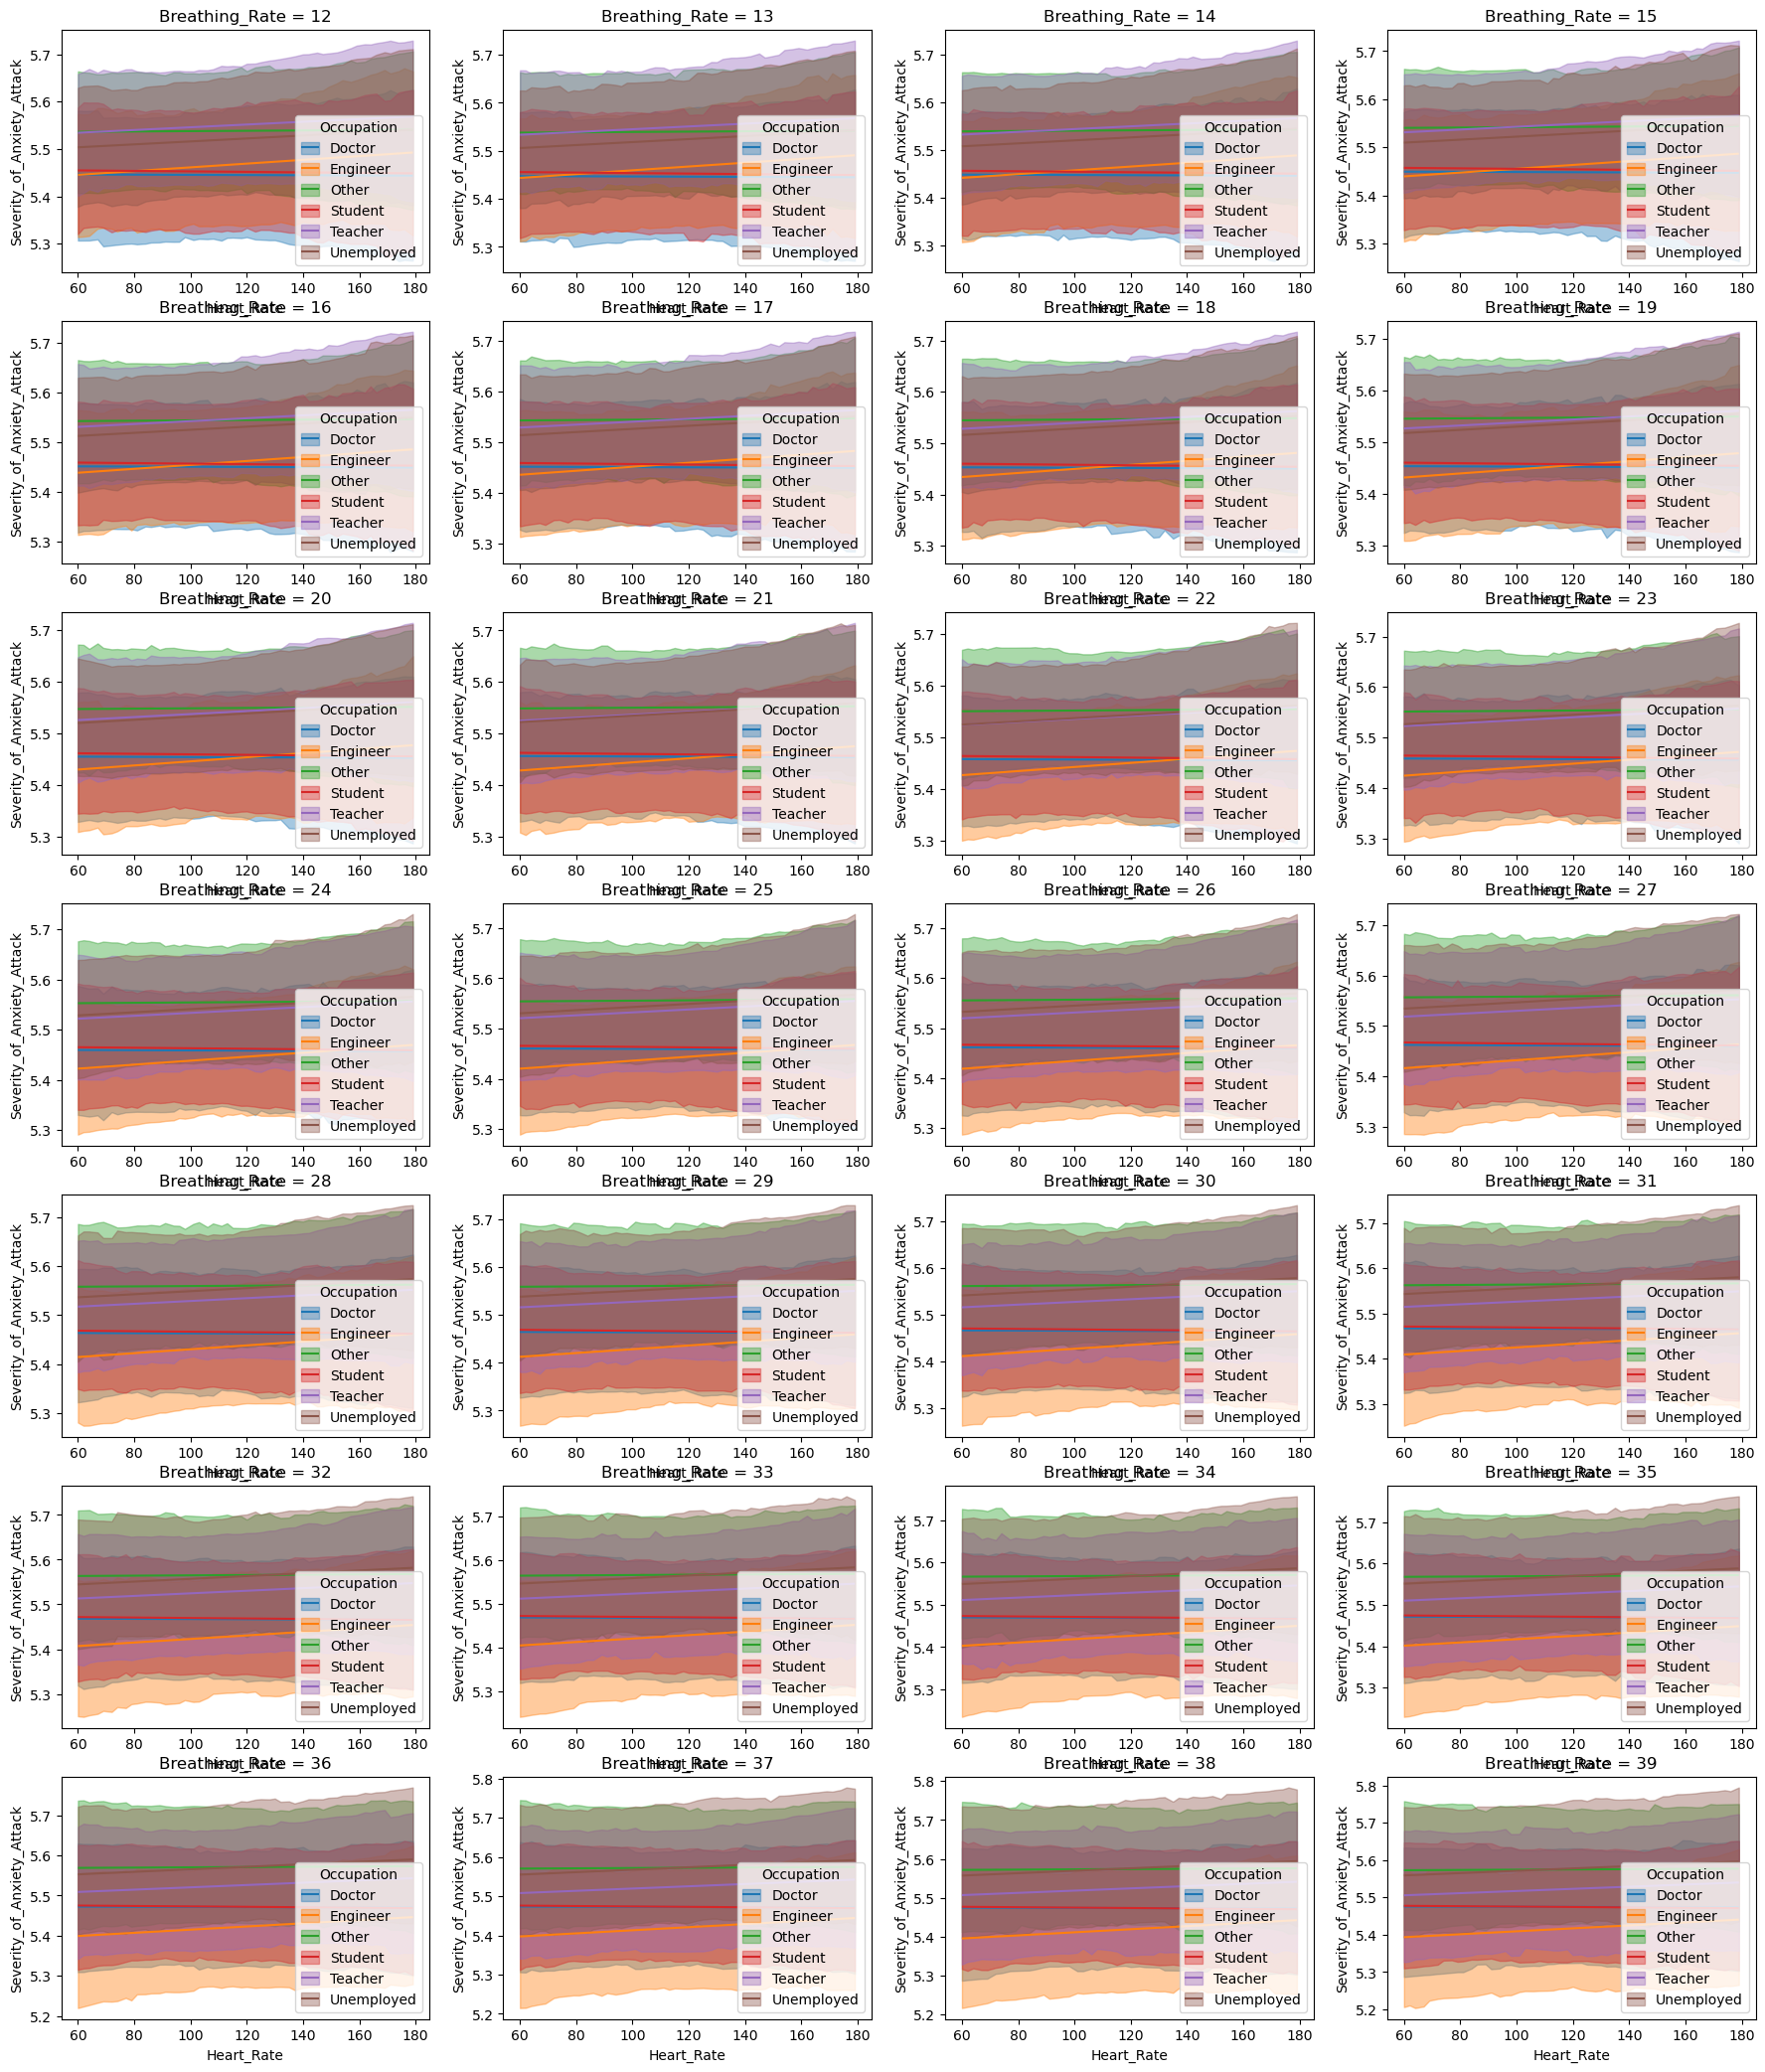

In [59]:

bmb.interpret.plot_predictions(
    model3_physicalactivity_interaction,
    idata_model3_physicalactivity_interaction,
    ["Heart_Rate", "Occupation", "Breathing_Rate"],
    fig_kwargs={"figsize":(22, 26)})#,
    #legend=False)
     

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: Heart_Rate, Occupation, Sweating_Level
Default computed for unspecified variable: Breathing_Rate, Physical_Activity


(<Figure size 2200x2600 with 6 Axes>,
 array([[<Axes: title={'center': 'Sweating_Level = 1'}, xlabel='Heart_Rate', ylabel='Severity_of_Anxiety_Attack'>,
         <Axes: title={'center': 'Sweating_Level = 2'}, xlabel='Heart_Rate', ylabel='Severity_of_Anxiety_Attack'>,
         <Axes: title={'center': 'Sweating_Level = 3'}, xlabel='Heart_Rate', ylabel='Severity_of_Anxiety_Attack'>],
        [<Axes: title={'center': 'Sweating_Level = 4'}, xlabel='Heart_Rate', ylabel='Severity_of_Anxiety_Attack'>,
         <Axes: title={'center': 'Sweating_Level = 5'}, xlabel='Heart_Rate', ylabel='Severity_of_Anxiety_Attack'>,
         <Axes: xlabel='Heart_Rate', ylabel='Severity_of_Anxiety_Attack'>]],
       dtype=object))

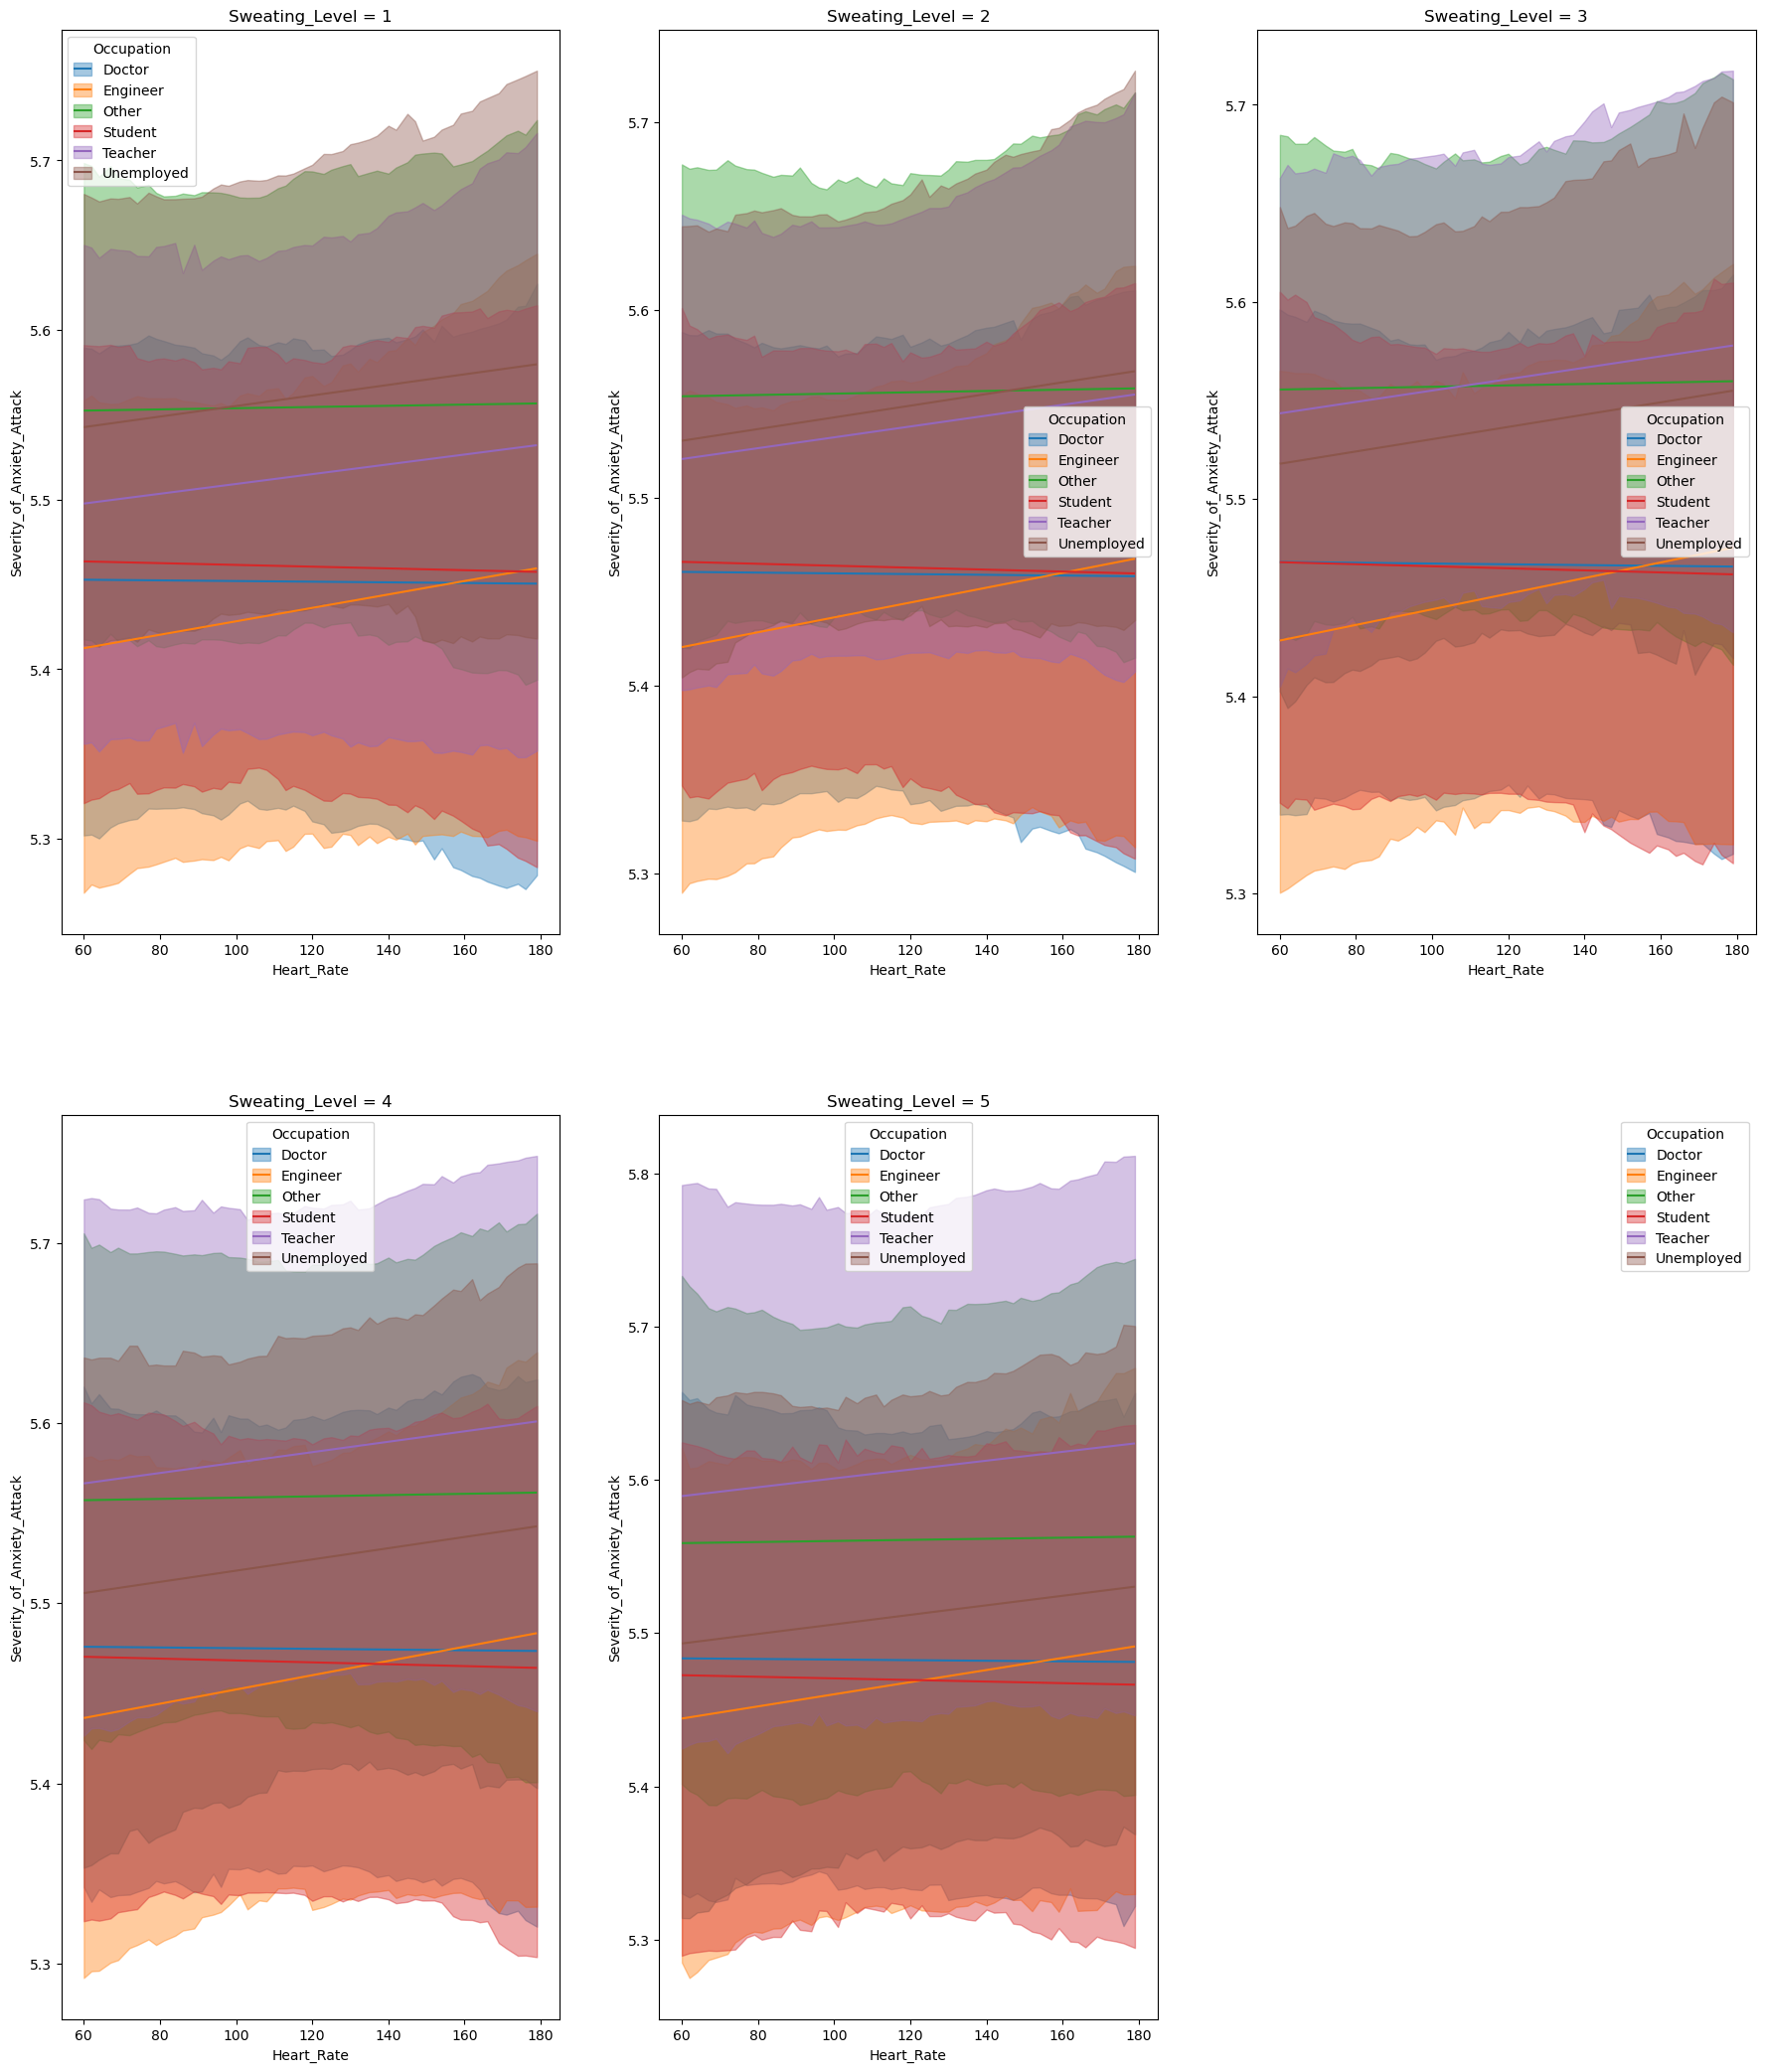

In [60]:
bmb.interpret.plot_predictions(
    model3_physicalactivity_interaction,
    idata_model3_physicalactivity_interaction,
    ["Heart_Rate", "Occupation", "Sweating_Level"],
    fig_kwargs={"figsize":(22, 26)})#,
    #legend=False)
     

c:\Users\ashwi\anaconda3\envs\jupyter\Lib\site-packages\arviz\rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
Default computed for conditional variable: Breathing_Rate, Occupation, Sweating_Level
Default computed for unspecified variable: Heart_Rate, Physical_Activity


(<Figure size 2200x2600 with 6 Axes>,
 array([[<Axes: title={'center': 'Sweating_Level = 1'}, xlabel='Breathing_Rate', ylabel='Severity_of_Anxiety_Attack'>,
         <Axes: title={'center': 'Sweating_Level = 2'}, xlabel='Breathing_Rate', ylabel='Severity_of_Anxiety_Attack'>,
         <Axes: title={'center': 'Sweating_Level = 3'}, xlabel='Breathing_Rate', ylabel='Severity_of_Anxiety_Attack'>],
        [<Axes: title={'center': 'Sweating_Level = 4'}, xlabel='Breathing_Rate', ylabel='Severity_of_Anxiety_Attack'>,
         <Axes: title={'center': 'Sweating_Level = 5'}, xlabel='Breathing_Rate', ylabel='Severity_of_Anxiety_Attack'>,
         <Axes: xlabel='Breathing_Rate', ylabel='Severity_of_Anxiety_Attack'>]],
       dtype=object))

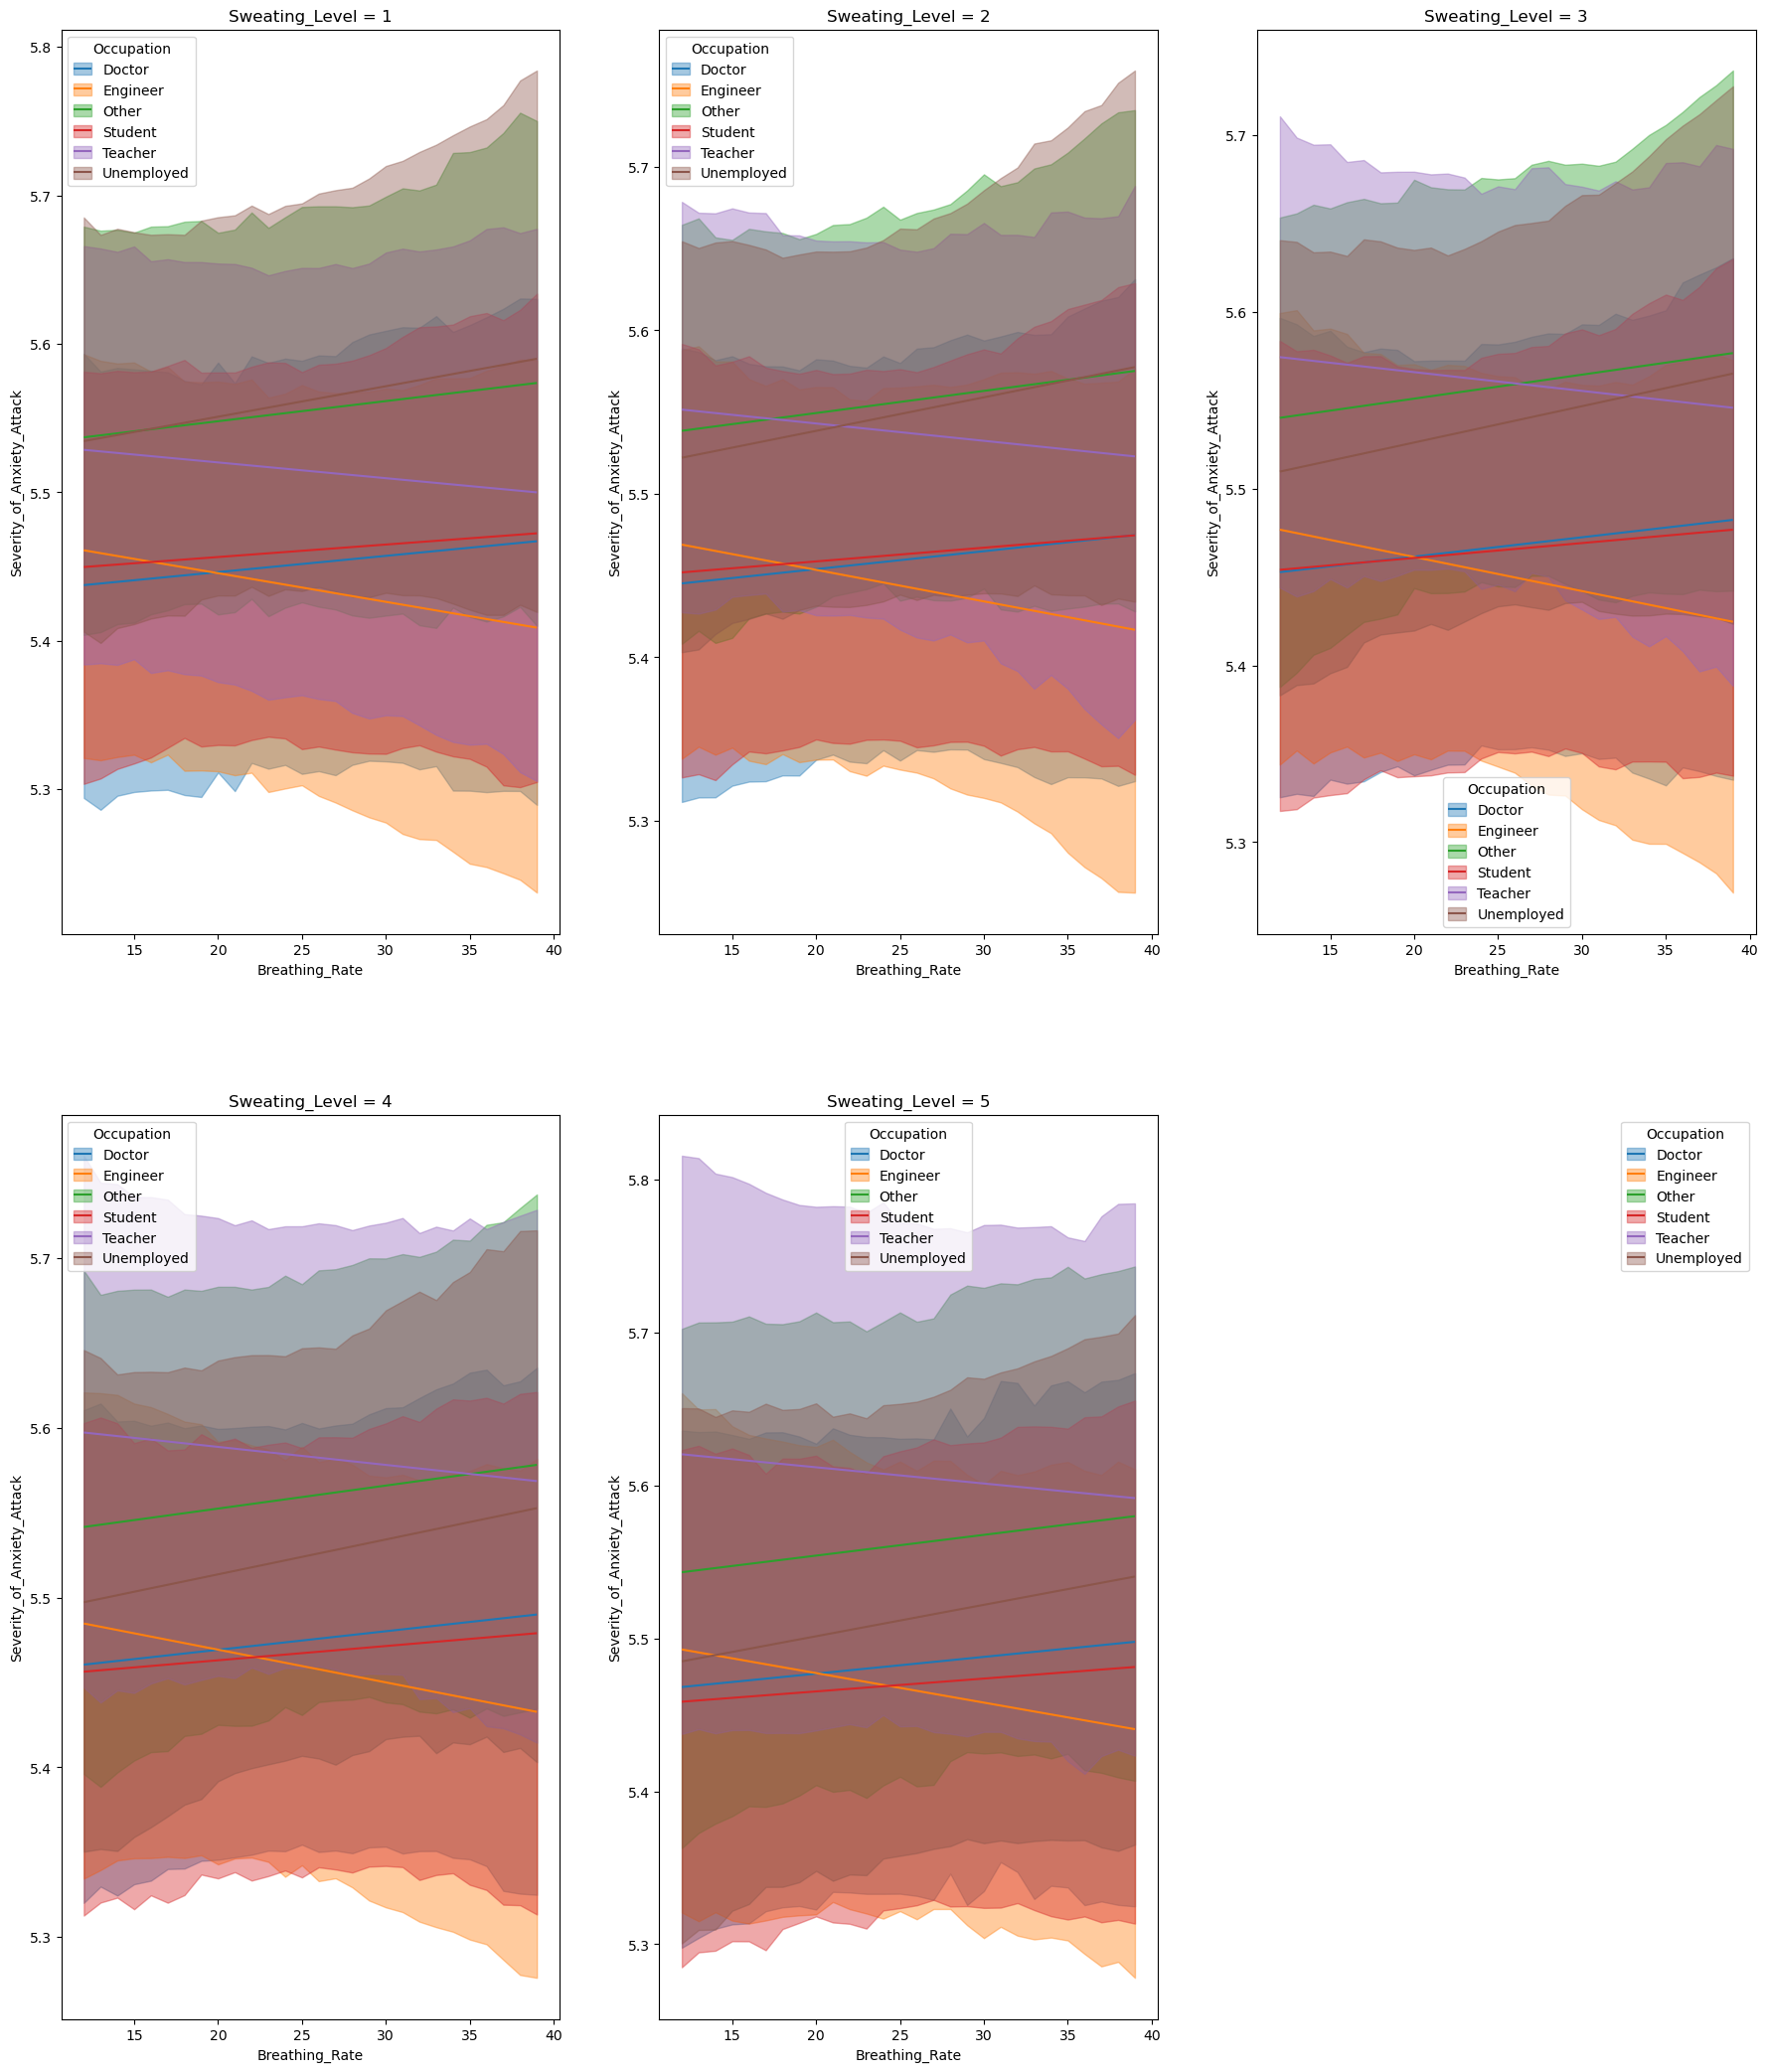

In [61]:
bmb.interpret.plot_predictions(
    model3_physicalactivity_interaction,
    idata_model3_physicalactivity_interaction,
    ["Breathing_Rate", "Occupation", "Sweating_Level"],
    fig_kwargs={"figsize":(22, 26)})#,
    #legend=False)
     

Honestly nothing much changed, it is similar to the conclusions I drew from the previous model. I think the heart rate x breathing rate graphs might effect severity less because of the interaction to physical acitivty but that is a very small difference. 

# Final Conclusions

This project aimed to create a model to predict the severity of anxiety attacks based on different behavioral, physiological, and lifestyle factors. I built multiple models and tested how different variables interacted to see if any had a strong effect on anxiety severity.  

The results show that **no single factor or group of factors strongly predicts the severity of an anxiety attack**. When comparing the models using **elpd_loo**, there was little difference between them, meaning that no clear patterns stood out. Even though factors like **heart rate, breathing rate, sweating level, and occupation** were included, none showed a strong or consistent impact on anxiety severity.  

The **physiological response models**, which included heart rate and breathing rate, performed slightly better than other models, but the difference was small. **Occupation** seemed to be an independent factor, meaning it did not change based on the physiological responses. Among all variables, **sweating level** had the most consistent impact, while **heart rate and breathing rate** had minor effects.  

Several reasons might explain why the models did not find strong patterns:  
- **Self-Reported Data Bias** – Since participants reported their own anxiety and stress levels, the data might not be completely accurate.  
- **Measurement Variability** – Anxiety is complex and influenced by many things that might not have been included in this dataset.  
- **Unmodeled Confounders** – Factors like **genetics, long-term mental health history, or real-time stressors** were not included but could have affected the results.  
- **Question Bias** - This data was yoinked off of kaggle so the data collection methods/questions they asked could have been misleading.

In the end, while these models did not find a strong link between specific behaviors and anxiety severity, this project shows how complicated anxiety prediction is.

This project highlights the **complexity of anxiety** and suggests that while some physiological factors may have small effects, it isn't directly linked to severity of an anxiety attack.